In [1]:
import itertools
from tqdm import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

font = {'size'   : 17}

matplotlib.rc('font', **font)
#matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 5, 5
#plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{K}{2}
$$
$$
d_1 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{J}{2}
$$
$$
d_2 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{J}{4} + \frac{K}{4}
$$

In [2]:
def den(w, D, U, J, K):
    d0 = w - 0.5 * D - U/2 + K/2
    d1 = w - 0.5 * D + U/2 + J/2
    d2 = w - 0.5 * D + J/4 + K/4
    return d0, d1, d2

# RG Equations

The RG equations for the symmetric spin-charge Anderson-Kondo are 

$$
\Delta U = 4|V|^2 \left[\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J}  - \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K}
$$

$$
\Delta V = \frac{V K}{16}\left(\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right) - \frac{3VJ}{4}\left( \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right)
$$

$$
\Delta J = - J^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

$$
\Delta K = - K^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

The following equation accepts the coupling values at the $j^{th}$ step of the RG, applies the RG equations on them and returns the couplings for the $(j-1)^{th}$ step. _If any coupling changes sign, it is set to 0._

In [3]:

def rg(w, D, U, V, J, K, count, flags):
    dens = den(w, D, U, J, K)
    deltaU = int(flags[0])*int(flags[1])*int(flags[2])*(-4 * V**2 * (1/dens[0] - 1/dens[1]) - (3* (J**2 - K**2)/8) * (count - 1) / dens[2])
    deltaV = int(flags[0])*int(flags[1])*int(flags[2])*((1/16) * K * V * (1/dens[0] - 1/dens[2]) - (3/4) * J * V * (1/dens[1] + 1/dens[2]))
    deltaJ = - int(flags[2]) * J**2 / dens[2]
    deltaK = - int(flags[2]) * K**2 / dens[2]

    #n = 2*np.pi*N*sqrt(D/Df)
    n = 1
    U = 0 if (U + n*deltaU) * U <= 0 else U + n*deltaU
    V = 0 if (V + n*deltaV) * V <= 0 else V + n*deltaV
    J = 0 if (J + n*deltaJ) * J <= 0 else J + n*deltaJ
    K = 0 if (K + n*deltaK) * K <= 0 else K + n*deltaK

    return U, V, J, K

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [4]:
def complete_RG(w, D0, U0, V0, J0, K0, keep=False):
    N = D0*10
    U = U0
    V = V0
    J = J0
    K = K0
    old_den = den(w, D0, U, J, K)
    x, y1, y2, y3, y4, y5 = [], [], [], [], [], []
    flag = False
    count = N+1
    flags = [True]*3
    for D in np.linspace(D0, 0, N):
        count -= 1
        if keep == True:
            x.append(D)
            y1.append(U)
            y2.append(J)
            y3.append(K)
            y4.append(V)
            y5.append(count)
        new_den = den(w, D, U, J, K)
        for i in range(len(old_den)):
            if old_den[i] * new_den[i] <= 0:
                flags[i] = False
        if flags[2] == False:
            flag = True
            break
        old_den = new_den
        U, V, J, K = rg(w, D, U, V, J, K, count, flags)
    if keep == False:
        x = [D0, D]
        y1 = [U0, U]
        y2 = [J0, J]
        y3 = [K0, K]
        y4 = [V0, V]
        y5 = [N, count]
    return x, y1, y2, y3, y4, flag, y5

# 1. $V=0$

First we will look at the simplified case of $V=0$. Since the RG equation for $V$ involves $V$, it will not flow. We need to look only at $U$, $J$ and $K$. Depending on the value of $\omega$, the denominator can be either positive or negative. We look at the two cases separately.

## a. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K>0$ (high $\omega$):

These aren't truly URG fixed points because the denominator will not converge towards zero.

### i. $J=K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be marginal here.

False


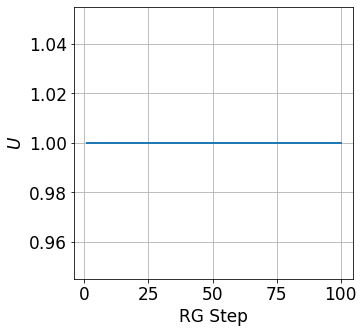

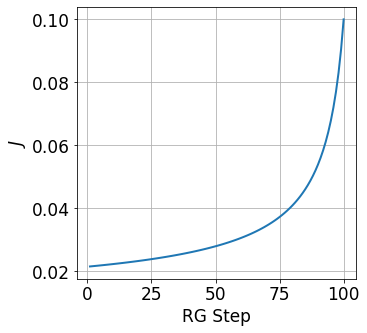

In [5]:
w = 6
D0 = 10
U0 = 1
J0 = K0 = 0.1
V0 = 0
Df = D0/2
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
print (flag)
plt.ylabel(r'$U$')
plt.xlabel(r'RG Step')
plt.plot(y5, y1)
plt.show()
plt.ylabel(r'$J$')
plt.xlabel(r'RG Step')
plt.plot(y5, y2)
plt.show()

### ii. $J > K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be irrelevant here.

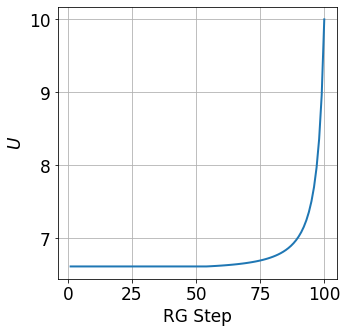

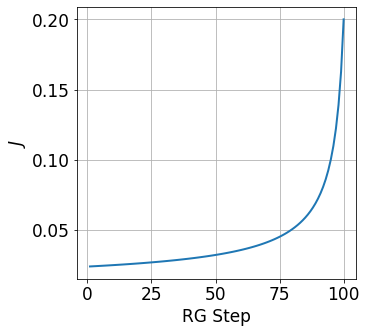

In [6]:
w = 6
D0 = 10
U0 = 10
J0 = 0.2
K0 = 0.1
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
plt.ylabel(r'$U$')
plt.xlabel(r'RG Step')
plt.plot(y5, y1)
plt.show()
plt.ylabel(r'$J$')
plt.xlabel(r'RG Step')
plt.plot(y5, y2)
plt.show()

### iii. $J < K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be relevant here.

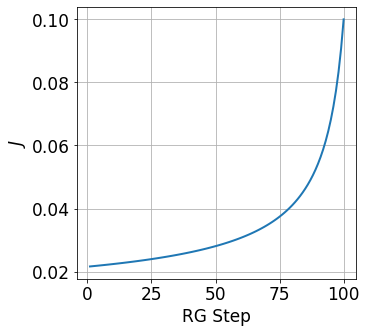

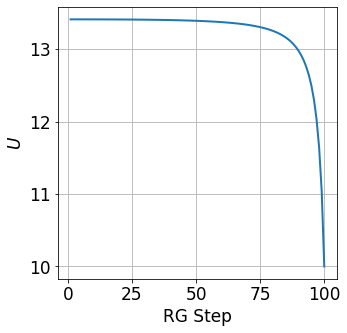

In [7]:
w = 6
D0 = 10
U0 = 10
J0 = 0.1
K0 = 0.2
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
plt.ylabel(r'$J$')
plt.xlabel(r'RG Step')
plt.plot(y5, y2)
plt.show()
plt.xlabel(r'RG Step')
plt.ylabel(r'$U$')
plt.plot(y5, y1)
plt.show()

## b. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K<0$ (low $\omega$):

This is the regime where we achieve true strong-coupling fixed points in $J,K$. The signature of $K^2 - J^2$ will determine whether $U$ is relevant or irrelevant.

### i. $J>K$

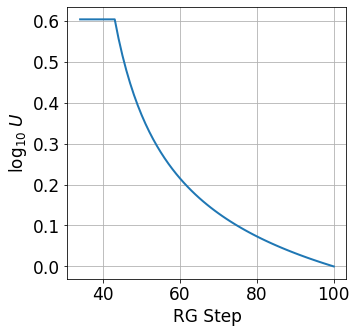

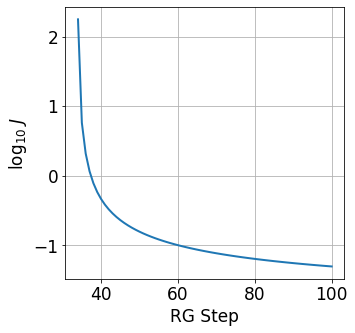

In [8]:
w = 0.01
D0 = 10
U0 = 1
J0 = 0.05
K0 = 0.04
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
if flag == True:
    plt.ylabel(r'$\log_{10}\;U$')
    plt.plot(y5, np.log10(y1))
    plt.xlabel(r'RG Step')
    plt.show()
    plt.ylabel(r'$\log_{10}\;J$')
    plt.xlabel(r'RG Step')
    plt.plot(y5, np.log10(y2))
    plt.show()
else:
    print ("Not fixed point.")

### i. $J<K$

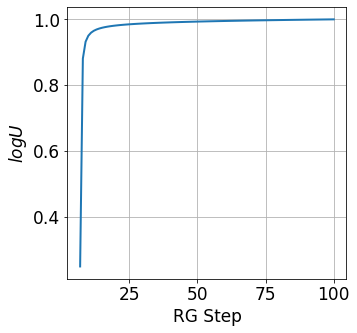

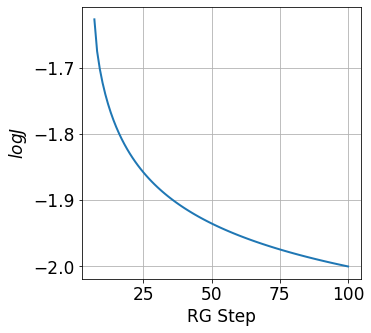

In [9]:
w = 0.01
D0 = 10
U0 = 10
J0 = 0.01
K0 = 0.02
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
if flag == True:
    plt.ylabel(r'$log U$')
    plt.xlabel(r'RG Step')
    plt.plot(y5, np.log10(y1))
    plt.show()
    plt.ylabel(r'$log J$')
    plt.xlabel(r'RG Step')
    plt.plot(y5, np.log10(y2))
    plt.show()
else:
    print ("Not fixed point.")

To wrap up the $V=0$ case, we look at an RG-invariant:

$\frac{\Delta J}{\Delta K} = \frac{J^2}{K^2} \implies \frac{1}{J} - \frac{1}{K} = \frac{1}{J_0} - \frac{1}{K_0}$

Note that this is an invariant even when $V$ is turned on.

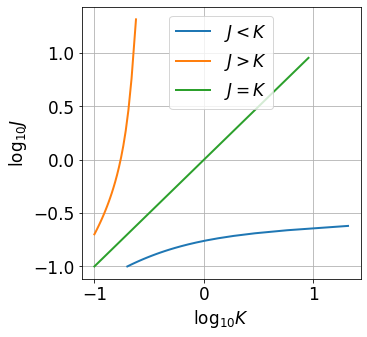

In [10]:
w = 0.1
D0 = 10
U0 = 10
J0 = 0.1
K0 = 0.2
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
plt.xlabel(r"$\log_{10}K$")
plt.ylabel(r"$\log_{10}J$")
plt.plot(np.log10(y3), np.log10(y2), label=r'$J<K$')
J0 = 0.2
K0 = 0.1
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
plt.plot(np.log10(y3), np.log10(y2), label=r'$J>K$')
J0 = 0.1
K0 = 0.1
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
plt.plot(np.log10(y3), np.log10(y2), label=r'$J=K$')
plt.legend()
plt.show()

## Phase Diagram

<img src="../figures/phases.svg" align="left" width=50%>


# 2. $V > 0$

The inclusion of $V$ will mean that there will not by any sharply defined phase of $U^*$ any more. We will still be working in the regime where $J,K$ flow to strong-coupling, and since those RG equations do not depend on $V$, their flows are unchanged. The behaviour of $U$ will get complicated however. To make 
sense, we will see how the total (over a range of $\omega$ and bare $U$) number of fixed points where $U^* > U_0$ and the total number of fixed points where $U^* < U_0$, in each of the four quadrants of the phase diagram, varies against the bare value $V_0$.

True


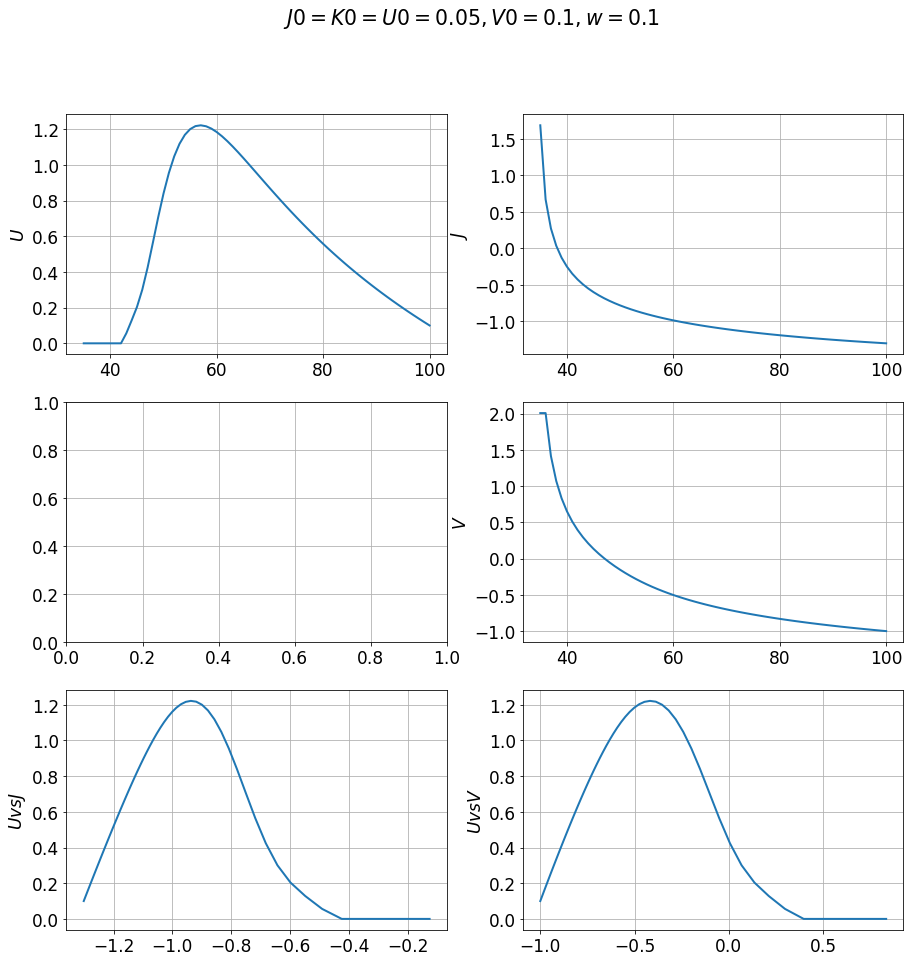

In [11]:
J0 = 0.05
K0 = 0
U0 = 0.1
V0 = 0.1
w = 0.1
D0 = 10
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0, keep=True)
print (flag)
fig, ax = plt.subplots(3,2)
fig.set_size_inches(15,15)
ax[0][0].plot(y5, y1)
ax[0][0].set_ylabel(r"$U$")
ax[0][1].plot(y5, np.log10(y2))
ax[0][1].set_ylabel(r"$J$")
ax[1][1].plot(y5, np.log10(y4))
ax[1][1].set_ylabel(r"$V$")
ax[2][0].plot(np.log10(y2)[:-4], y1[:-4])
ax[2][0].set_ylabel(r"$U vs J$")
ax[2][1].plot(np.log10(y4)[:-4], y1[:-4])
ax[2][1].set_ylabel(r"$U vs V$")
plt.suptitle(r"$J0=K0=U0={}, V0={}, w ={}$".format(J0, V0, w))
plt.show()

## a. Behaviour of distribution of fixed points as a function of bare $V$

We can classify the fixed points into three classes: $U*=0$, $U^* > U_0$ and $U^* < U_0$. The number of fixed points in each class for $V=0$ has already been clarified in the $V=0$ section, specially in the phase diagram. For that, we will first create some helper functions.
- count_fp(args): returns the fraction of fixed points with $U^*=0$ ($c_0$), $U^* > U_0$ ($c_1$) and $U^* < U_0$ ($c_2$), for given values of $D_0, V_0, J_0, K_0$
- get_Vc(args): returns the critical $V_0$ at which $c_0=c_1+c_2$
- plot_count(args): just plots the fraction of fixed points in each class as a function of bare values, given the data
- plot_frac(args): just plots the fraction of $U^*=0$ or $U^* \neq 0$ fixed points a particular $V_0$, as a function of $D$

In [12]:
def count_fp(D0, V0, J0, K0, sign, delta=0.01):
    w_range = np.arange(-D0/2, D0/2 - J0/4 - K0/4, delta)
    U_range = np.arange(sign*delta, sign*(5 + delta), sign*delta)
    data = itertools.product(w_range, [D0], U_range, [V0], [J0], [K0])
    count = np.zeros(6)
    for outp in Pool(processes=40).starmap(complete_RG, data):
        U0 = outp[1][0]
        U_fp = outp[1][-1]
        V0 = outp[4][0]
        V_fp = outp[4][-1]
        count += np.array([U_fp == 0, U_fp > U0 and outp[-2] == True, U_fp < U0 and outp[-2] == True, V_fp == 0, V_fp > V0 and outp[-2] == True, V_fp < V0 and outp[-2] == True])
    return count

In [13]:
def get_Vc(V0_range, c0, c1):
    diff = (c1-c0)[0]
    for i in range(1,len(c1-c0)):
        if diff * (c1-c0)[i] <=0 :
            return V0_range[i]
    return -1

In [14]:
def plot_count(V0_range, countU, countV, title):
    y = [np.array(c)/sum(countU) for c in countU]
    z = [np.array(d)/sum(countV) for d in countV]
    plt.plot(V0_range, y[0], color='r', label=r"$U^*=0$")
    plt.plot(V0_range, y[1], color='b', label=r"$U^* > U_0$")
    plt.plot(V0_range, y[2], color='g', label=r"$U^* < U_0$")
    plt.legend()
    plt.title(title)
    plt.xlabel(r"$V_0$")
    plt.ylabel(r"fraction of fixed points of $U^*$")
    plt.show()
    #plt.plot(V0_range, z[0], color='r', label=r"$V^*=0$")
    #plt.plot(V0_range, z[1], color='b', label=r"$V^* > V_0$")
    #plt.plot(V0_range, z[2], color='g', label=r"$V^* < V_0$")
    #plt.legend()
    #plt.title(title)
    #plt.xlabel(r"$V_0$")
    #plt.ylabel(r"fraction of fixed points of $V^*$")
    #plt.show()

In [15]:
def plot_frac(D0_range, V0, frac, title):
    plt.plot(D0_range, frac[0])
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"ratio of $U^*=0$ and $U^*\neq 0$")
    plt.title(title+" $V_0 = {}$".format(V0[0]))
    plt.show()
    plt.plot(D0_range, frac[1])
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"ratio of $U^*=0$ and $U^*\neq 0$")
    plt.title(title+" $V_0 = {}$".format(V0[1]))
    plt.show()

We will first check how the $c_i$ vary as functions of $V$, in each quadrant.

In [16]:
def sweep_V(J0, K0, sign, V0_range, D0_range=range(5, 21, 3)):
    Usign = r"$U > 0$" if sign == 1 else r" $U < 0$"
    for D0 in D0_range:
        c0, c1, c2 = [], [], []
        d0, d1, d2 = [], [], []
        for V0 in tqdm(V0_range):
            count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
            c0.append(count[0])
            c1.append(count[1])
            c2.append(count[2])
            d0.append(count[3])
            d1.append(count[4])
            d2.append(count[5])
        c0, c1, c2 = np.array(c0), np.array(c1), np.array(c2)
        d0, d1, d2 = np.array(d0), np.array(d1), np.array(d2)
        plot_count(V0_range, [c0, c1, c2], [d0, d1, d2], r"$D={}, J={}, K={},$".format(D0, J0, K0)+Usign)

## First Quadrant: $U>0, J>K$

100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


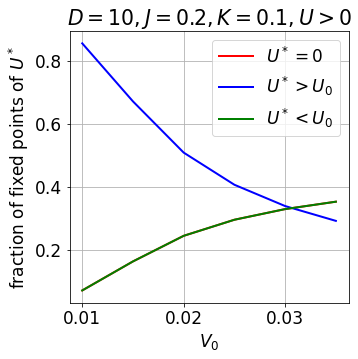

100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


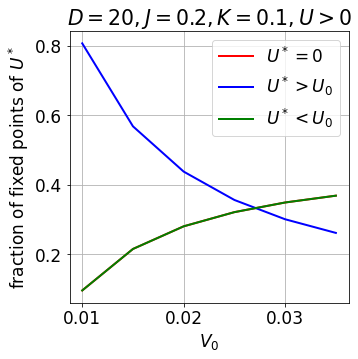

100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


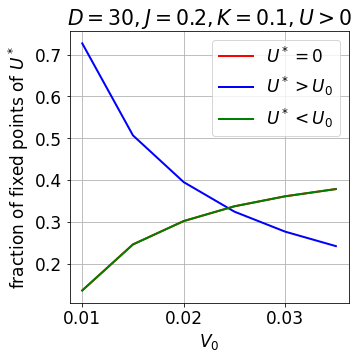

100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


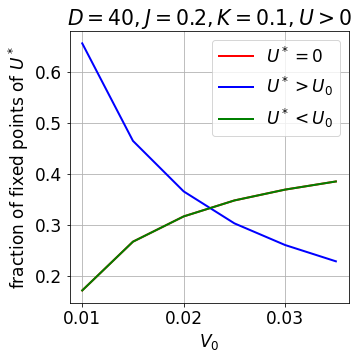

100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


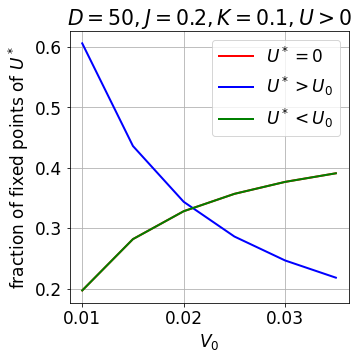

In [26]:
sweep_V(0.2, 0.1, 1, np.arange(0.01, 0.04, 0.005), np.arange(10, 51, 10))
#sweep_V(0.2, 0.1, 1, np.arange(0.01,0.02+0.001,0.001), np.arange(4,5,1))

As $D$ increases, dominant fixed point switches from $U^*>0$ to $U^*=0$ at some critical $V_c$. The critical V appears to decrease with D initially, but later increases (shown later). For large $D$, this critical V will be inaccessible, and the flip will be forbidden, leading to a phase where $U^*>U_0$. 

## Second Quadrant: $U>0, J<K$

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


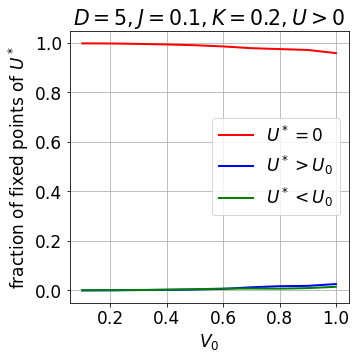

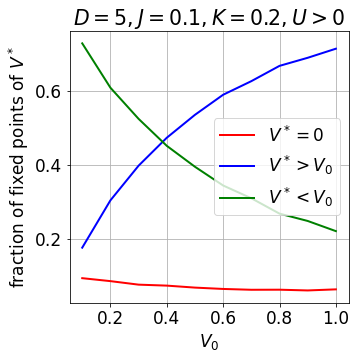

100%|██████████| 10/10 [01:13<00:00,  7.40s/it]


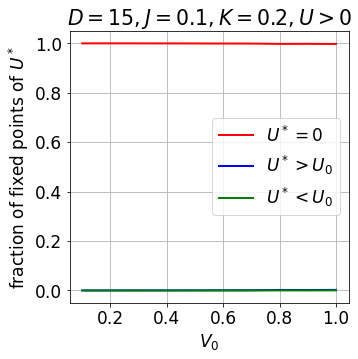

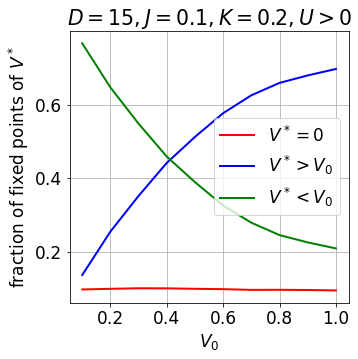

100%|██████████| 10/10 [02:27<00:00, 14.71s/it]


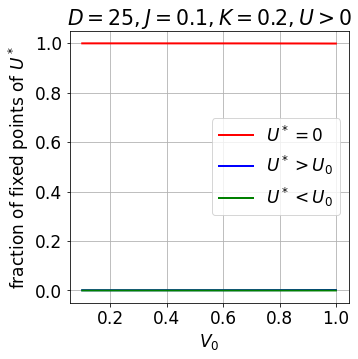

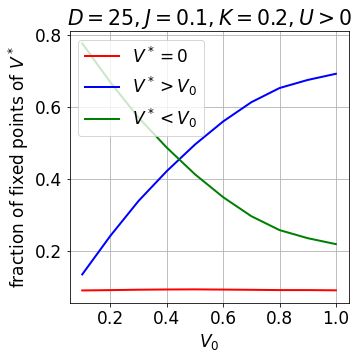

100%|██████████| 10/10 [04:16<00:00, 25.63s/it]


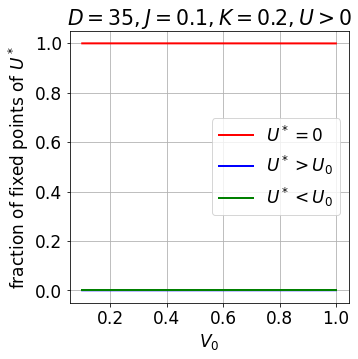

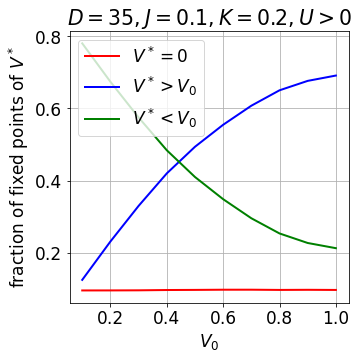

100%|██████████| 10/10 [06:14<00:00, 37.42s/it]


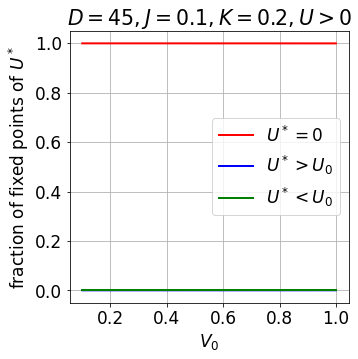

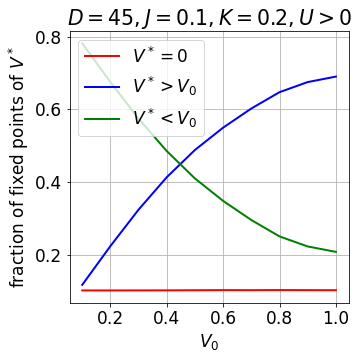

 50%|█████     | 5/10 [04:35<04:35, 55.08s/it]

In [18]:
sweep_V(0.1, 0.2, 1, np.arange(0.1,1.1,0.1), np.arange(5, 56, 10))

In [ ]:
sweep_V(0.1, 0.2, 1, r"second quadrant", np.arange(2,9,1), np.arange(50,101,10))

With increase in $D$, the hump keeps moving forward, and disappears at a sufficiently large $D$, so the dominant behaviour is unchanged (still $U^*=0$).

## Third Quadrant: $U<0, J<K$

100%|██████████| 17/17 [00:37<00:00,  2.23s/it]


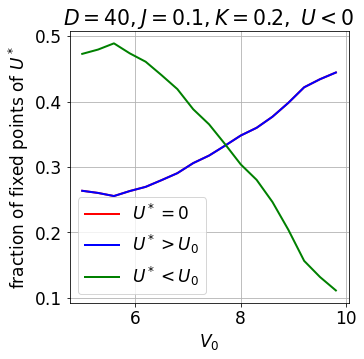

100%|██████████| 17/17 [00:52<00:00,  3.11s/it]


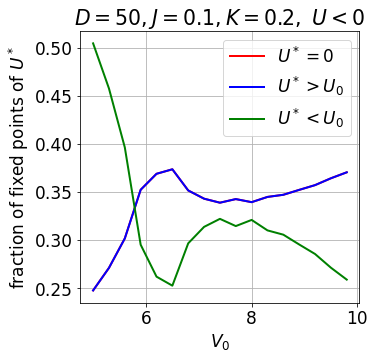

100%|██████████| 17/17 [01:13<00:00,  4.31s/it]


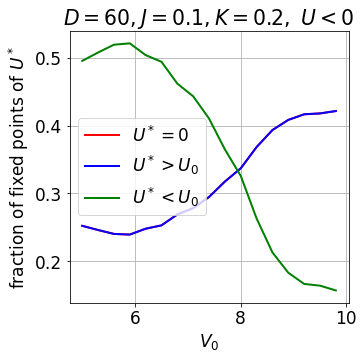

100%|██████████| 17/17 [01:35<00:00,  5.62s/it]


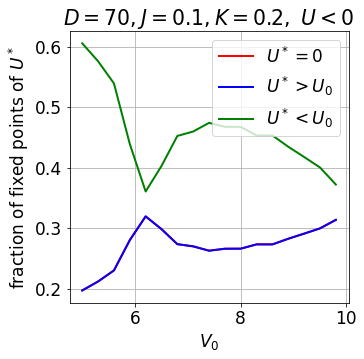

In [17]:
sweep_V(0.1, 0.2, -1, np.arange(5, 10.1, 0.3), np.arange(40,71,10))

We see the opposite of the first quadrant behaviour here. There is again a flip at some critical V, critical V initially increases and then decreases. The fixed point phase should be $U^*<U_0$.

## Fourth Quadrant: $U<0, J>K$

100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


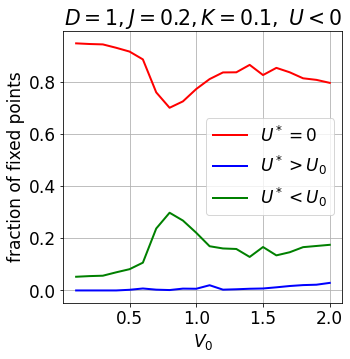

100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


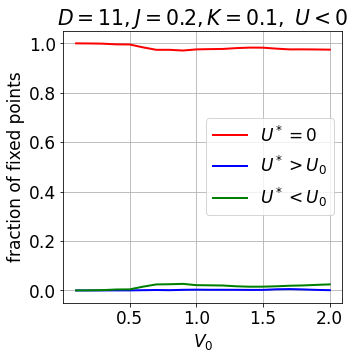

100%|██████████| 20/20 [02:21<00:00,  7.08s/it]


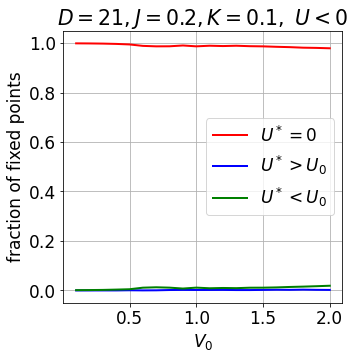

100%|██████████| 20/20 [04:20<00:00, 13.02s/it]


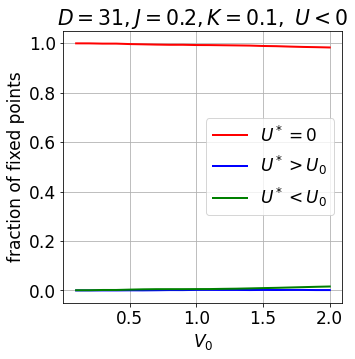

100%|██████████| 20/20 [06:23<00:00, 19.20s/it]


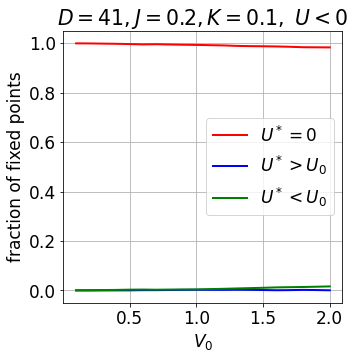

100%|██████████| 20/20 [08:25<00:00, 25.29s/it]


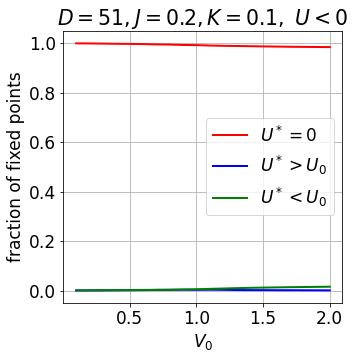

100%|██████████| 20/20 [10:36<00:00, 31.84s/it]


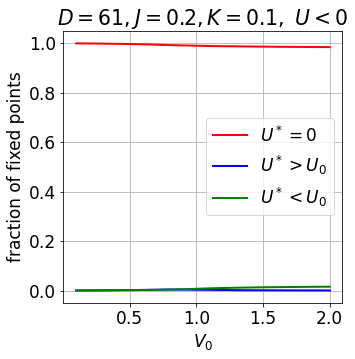

100%|██████████| 20/20 [12:35<00:00, 37.77s/it]


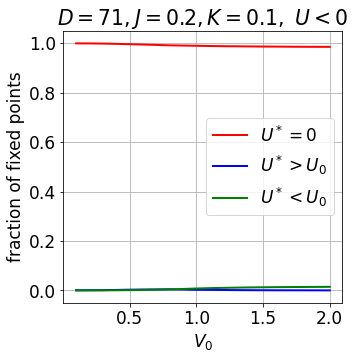

100%|██████████| 20/20 [14:51<00:00, 44.56s/it]


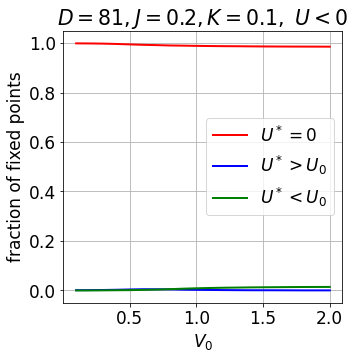

100%|██████████| 20/20 [16:18<00:00, 48.90s/it]


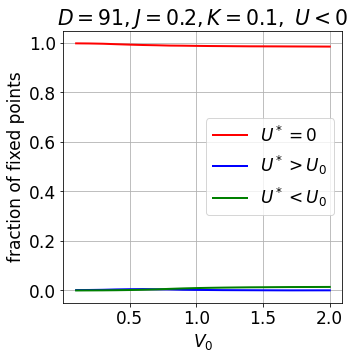

100%|██████████| 20/20 [18:05<00:00, 54.29s/it]


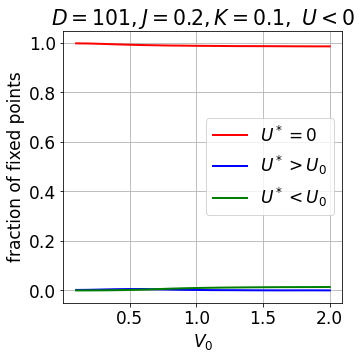

4

In [17]:
open("file1.txt", "w").write("Start")
sweep_V(0.2, 0.1, -1, np.arange(0.1,2.1,0.1), np.arange(1,102,10))
open("file2.txt", "w").write("Done")

In the fourth quadrant, the $V$ causes significant changes only at very small $D$.

## $\frac{c_0}{c_1}$ at $V_0=0.02$ and $V_c$, both vs $D$, for the $1^\text{st}$ quadrant

In [23]:
def plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign):
    Vc = []
    index = 1 if sign == 1 else 2
    for D0 in D0_range:
        print (D0)
        deltaV = -0.01 if V0_start > V0_end else 0.01
        while np.abs(deltaV) >= np.abs(delta):
            flag = 0
            diff1 = 0
            diff2 = 0
            V1 = V2 = -1
            for V0 in np.arange(V0_start, V0_end+deltaV, deltaV):
                count = count_fp(D0, V0, J0, K0, sign, delta=0.05)
                if diff1 == 0:
                    diff1 = count[0] - count[index]
                    diff2 = count[3] - count[4]
                elif np.abs(deltaV) > np.abs(delta):
                    if diff1*(count[0]-count[index]) <= 0 or diff2*(count[3]-count[4]) <= 0:
                        flag = 2
                        print (V0)
                        break
                else: 
                    if diff1*(count[0]-count[index]) <= 0 and V1 == -1:
                        V1 = V0
                        flag += 1
                        print ("1", V1)
                    if diff2*(count[3]-count[4]) <= 0 and V2 == -1:
                        V2 = V0
                        flag += 1
                        print ("2", V2)
                    if flag == 2:
                        break
            
            if  flag != 2:
                deltaV *= -1
                V0_end = 0.5 if V0_end == 0 else 0
            else:
                V0_start = max(V1, V2, V0) - deltaV
                deltaV /= 10
        Vc.append([D0, V1, V2])
        print (V1, V2)
    Vc = np.array(Vc)
    return Vc

In [21]:
def plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign):
    Vc = []
    index = 1 if sign == 1 else 2
    for D0 in D0_range:
        print (D0)
        deltaV = -0.01 if V0_start > V0_end else 0.01
        while np.abs(deltaV) >= np.abs(delta):
            flag = False
            diff = 0
            for V0 in np.arange(V0_start, V0_end+deltaV, deltaV):
                count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
                if diff == 0:
                    diff = count[0] - count[index]
                elif diff * (count[0]-count[index]) <= 0:
                        flag = True
                        print (V0)
                        break
            
            if  flag == False:
                deltaV *= -1
                V0_end = 0.5 if V0_end == 0 else 0
            else:
                V0_start = V0 - deltaV
                deltaV /= 10
        Vc.append([D0, V0])
        print (V0)
    Vc = np.array(Vc)
    return Vc

10
0.03
0.029999999999999992
0.029999999999999992
20
0.02099999999999999
0.02599999999999999
0.02599999999999999


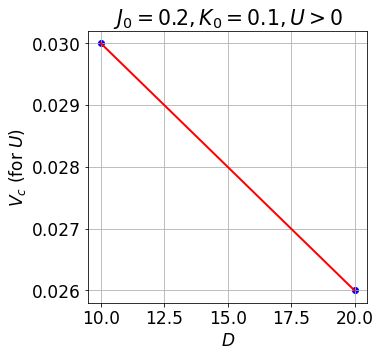

In [27]:
sign = 1
J0 = 0.2
K0 = 0.1
V0_start = 0.04
V0_end = 0
delta = -0.001
D0_range = range(10, 520, 100)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
Vc = plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign)
plt.plot(Vc[:,0], Vc[:,1], color="r")
plt.scatter(Vc[:,0], Vc[:,1], marker="o", color="b")
plt.ylabel(r"$V_c$ (for $U$)")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()

In [27]:
sign = 1
J0 = 0.2
K0 = 0.1
V0_start = 0.02
V0_end = 0
delta = -0.001
D0_range = range(360, 520, 50)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
Vc = plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign)
plt.plot(Vc[:,0], Vc[:,1], color="r")
plt.scatter(Vc[:,0], Vc[:,1], marker="o", color="b")
plt.ylabel(r"$V_c$ (for $U$)")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()
plt.plot(Vc[:,0], Vc[:,2], color="r")
plt.scatter(Vc[:,0], Vc[:,2], marker="o", color="b")
plt.ylabel(r"$V_c$ (for $V$)")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()

360
0.0
1 0.009000000000000001
2 0.004000000000000005
0.009000000000000001 0.004000000000000005
410
1.734723475976807e-18
1 0.009000000000000001
Process ForkPoolWorker-10141:
Process ForkPoolWorker-10154:
Process ForkPoolWorker-10142:
Process ForkPoolWorker-10133:
Process ForkPoolWorker-10152:
Traceback (most recent call last):
Process ForkPoolWorker-10156:
Process ForkPoolWorker-10129:
Process ForkPoolWorker-10146:


KeyboardInterrupt: 

In [18]:
sign = 1
J0 = 0.2
K0 = 0.1
V0_start = 0.00899
V0_end = 0
delta = -0.01
D0_range = range(410, 520, 50)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
Vc = plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign)
plt.plot(Vc[:,0], Vc[:,1], color="r")
plt.scatter(Vc[:,0], Vc[:,1], marker="o", color="b")
plt.ylabel(r"critical V")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()

410
Process ForkPoolWorker-217:
Process ForkPoolWorker-221:
Process ForkPoolWorker-219:
Process ForkPoolWorker-225:
Process ForkPoolWorker-207:
Process ForkPoolWorker-201:
Process ForkPoolWorker-223:
Process ForkPoolWorker-237:
Process ForkPoolWorker-240:
Process ForkPoolWorker-210:
Process ForkPoolWorker-214:
Process ForkPoolWorker-239:
Process ForkPoolWorker-228:
Process ForkPoolWorker-218:
Process ForkPoolWorker-202:
Process ForkPoolWorker-231:
Process ForkPoolWorker-212:
Process ForkPoolWorker-233:
Process ForkPoolWorker-213:
Process ForkPoolWorker-216:
Process ForkPoolWorker-226:
Process ForkPoolWorker-222:
Process ForkPoolWorker-205:
Traceback (most recent call last):
Process ForkPoolWorker-232:
Process ForkPoolWorker-206:
Process ForkPoolWorker-230:
Process ForkPoolWorker-224:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call la

In [ ]:
sign = -1
J0 = 0.1
K0 = 0.2
V0_start = 0.2
V0_end = 5
delta = 0.0001
D0_range = np.arange()
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
Vc = plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign)
plt.plot(Vc[:,0], Vc[:,1], color="r")
plt.scatter(Vc[:,0], Vc[:,1], marker="o", color="b")
plt.ylabel(r"critical V")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()

30
0.0
0.02
0.0
0.002
0.004
0.006
0.008
0.008
40
0.0
0.02
0.0
0.002
0.004
0.006
0.008
0.01
0.01
50
0.0
0.02
0.0
0.002
0.004
0.006
0.008
0.01
0.012
0.014
0.014
60
0.0
0.02
0.0
0.002
0.004
0.006
0.008
0.01
0.012
0.014
0.016
0.018000000000000002
0.018000000000000002
70
0.0
0.02
0.04
0.02
0.022
0.023999999999999997
0.023999999999999997
80
0.0
0.02
0.04
0.02
0.022
0.023999999999999997
0.025999999999999995
0.027999999999999994
0.029999999999999992
0.029999999999999992
90
0.0
0.02
0.04
0.02
0.022
0.023999999999999997
0.025999999999999995
0.027999999999999994
0.029999999999999992
0.03199999999999999
0.03399999999999999
0.03599999999999999
0.03599999999999999
100
0.0
0.02
0.04
0.06
0.039999999999999994
0.041999999999999996
0.044
0.044
110
0.0
0.02
0.04
0.06
0.039999999999999994
0.041999999999999996
0.044
0.046
0.048
0.05
0.052000000000000005
0.054000000000000006
0.054000000000000006
120
0.0
0.02
0.04
0.06
0.08
0.06
0.062
0.062
130
0.0
0.02
0.04
0.06
0.08
0.06
0.062
0.064
0.066
0.068
0.07
0.0720

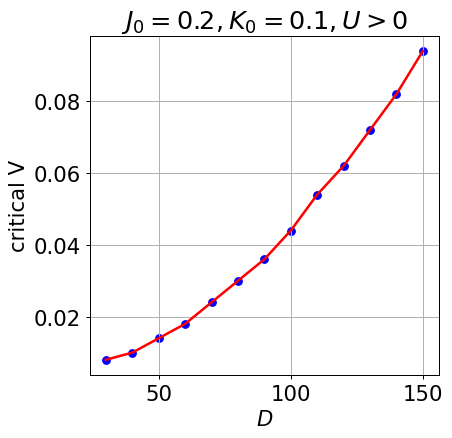

In [19]:
sign = 1
J0 = 0.2
K0 = 0.1
V0_start = 0.2
V0_end = 5
delta = 0.0001
D0_range = [20, 100, 200, 500, 1000]
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
Vc = plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign)
plt.plot(Vc[:,0], Vc[:,1], color="r")
plt.scatter(Vc[:,0], Vc[:,1], marker="o", color="b")
plt.ylabel(r"critical V")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()

The critical $V$ at which the transition from $U^*>U_0$ to $U^*=0$ occurs is a function of $D$ and $J,K$. It increases with increase in $D$, as well as increase in $J$. 

10
1.1099999999999994
11
1.1099999999999994
12
1.1799999999999995
13
1.2299999999999995
14
1.3499999999999996
15
1.3299999999999996
16
1.4299999999999997
17
1.4099999999999997
18
1.4799999999999998
19
1.5299999999999998


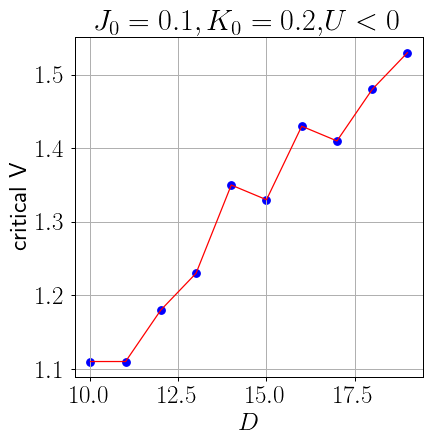

In [18]:
sign = -1
J0 = 0.1
K0 = 0.2
V0_start = 2.4
V0_end = 0
delta = -0.1
D0_range = range(30,61,3)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
Vc = plot_Vc(V0_start, V0_end, D0_range, delta, J0, K0, sign)
plt.plot(Vc[:,0], Vc[:,1], color="r")
plt.scatter(Vc[:,0], Vc[:,1], marker="o", color="b")
plt.ylabel(r"critical V")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()

102
1.1
122
0.6000000000000001
142
0.6000000000000001
162
0.7000000000000001
182
0.7000000000000001
202
0.9
222
1.0
242
1.1
262
0.6000000000000001
282
0.6000000000000001
302
0.6000000000000001


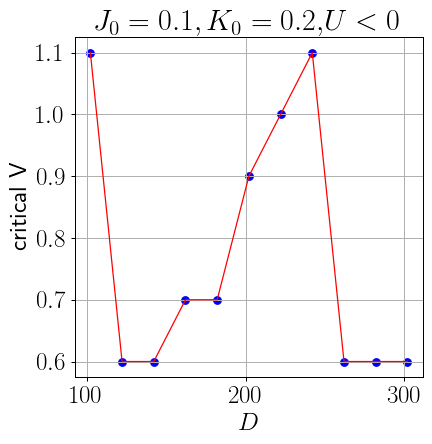

In [35]:
Vc, J0, K0, Usign = plot_Vc(0, range(102,303,20), 0.1, 0.1, 0.2, -1)
plt.plot(Vc[:,0], Vc[:,1], color="r")
plt.scatter(Vc[:,0], Vc[:,1], marker="o", color="b")
plt.ylabel(r"critical V")
plt.xlabel(r"$D$")
plt.title(r"$J_0 ={}, K_0 = {},$".format(J0,K0) + Usign)
plt.show()

## Variation of fractions with system size

In [37]:
def plot_frac(V0, D0_range, J0, K0, sign, inds):
    i, j = inds
    diff1 = []
    diff2 = []
    for D0 in tqdm(D0_range):
        count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
        diff1.append((count[i]-count[j]))
        diff2.append((count[4]-count[3]))

    #diff = np.array(diff)
    #return diff/min(np.abs(diff))
    return np.array(diff1), np.array(diff2)

100%|██████████| 6/6 [09:33<00:00, 95.63s/it] 


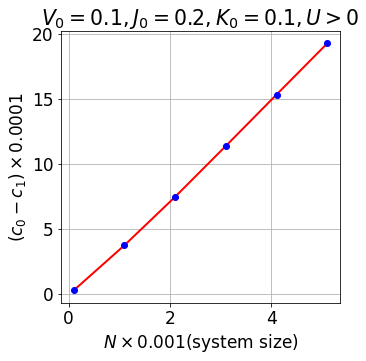

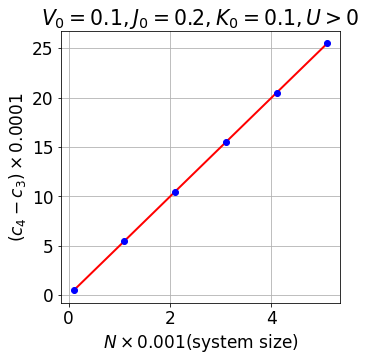

In [39]:
D0_range = np.arange(10,520,100)
J0 = 0.2
K0 = 0.1
inds = [0,1]
sign = 1
V0 = 0.1
diff1, diff2 = plot_frac(V0, D0_range, J0, K0, sign, inds)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
plt.plot(D0_range/100, diff1/10000, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"$(c_{} - c_{})\times 0.0001$".format(inds[0], inds[1]))
plt.xlabel(r"$N\times 0.001$(system size)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {}, $".format(V0,J0,K0)+Usign)
#plt.savefig("/home/abhirup/IPhD-Project-II/figures/frac_vs_D_quad1.pdf", bbox_inches='tight', format='pdf')
plt.show()
plt.plot(D0_range/100, diff2/10000, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"$(c_{} - c_{})\times 0.0001$".format(4, 3))
plt.xlabel(r"$N\times 0.001$(system size)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {}, $".format(V0,J0,K0)+Usign)
#plt.savefig("/home/abhirup/IPhD-Project-II/figures/frac_vs_D_quad1.pdf", bbox_inches='tight', format='pdf')
plt.show()

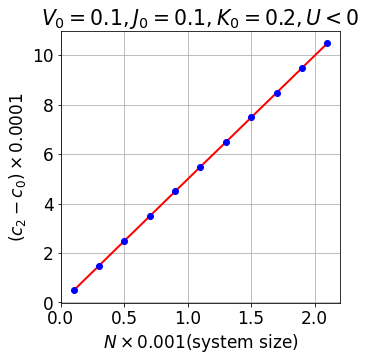

In [20]:
D0_range = np.arange(10,220,20)
J0 = 0.1
K0 = 0.2
inds = [2,0]
sign = -1
V0 = 0.1
#diff = plot_frac(V0, D0_range, J0, K0, sign, inds)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
plt.plot(D0_range/100, diff, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"$(c_{} - c_{})\times 0.0001$".format(inds[0], inds[1]))
plt.xlabel(r"$N \times 0.001$(system size)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {},$".format(V0,J0,K0)+Usign)
plt.show()

1
10
100
1000


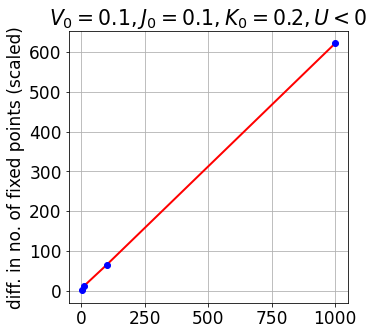

1
10
100
1000


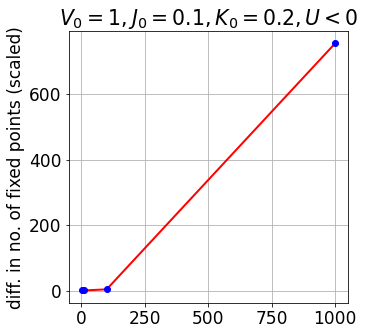

1
10
100
1000


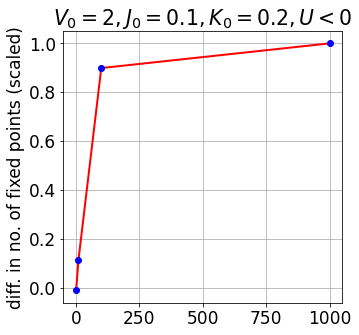

In [19]:
D0_range = [1, 10, 100, 1000]
J0 = 0.1
K0 = 0.2
inds = [2,0]
sign = -1
V0 = 0.1
diff1 = plot_frac(V0, D0_range, J0, K0, sign, inds)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
plt.plot(D0_range, diff1, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"diff. in no. of fixed points (scaled)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {},$".format(V0,J0,K0)+Usign)
plt.show()
V0 = 1
diff2 = plot_frac(V0, D0_range, J0, K0, sign, inds)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
plt.plot(D0_range, diff2, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"diff. in no. of fixed points (scaled)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {},$".format(V0,J0,K0)+Usign)
plt.show()
V0 = 2
diff3 = plot_frac(V0, D0_range, J0, K0, sign, inds)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
plt.plot(D0_range, diff3, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"diff. in no. of fixed points (scaled)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {},$".format(V0,J0,K0)+Usign)
plt.show()

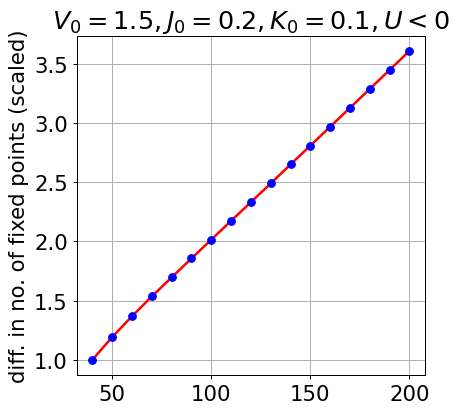

In [27]:
D0_range = range(40,201,10)
J0 = 0.2
K0 = 0.1
inds = [0, 2]
sign = -1
V0 = 1.5
diff = plot_frac(V0, D0_range, J0, K0, sign, inds)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
plt.plot(D0_range, diff, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"diff. in no. of fixed points (scaled)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {},$".format(V0,J0,K0)+Usign)
plt.show()

In [36]:
def plot_frac_V(V0, D0_range, J0, K0, sign, inds):
    i, j = inds
    diff = []
    for D0 in tqdm(D0_range):
        count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
        diff.append(count[4]-count[3])
    #diff = np.array(diff)
    #return diff/min(np.abs(diff))
    return np.array(diff)
    
D0_range = np.arange(10,520,50)
J0 = 0.2
K0 = 0.1
inds = [0,1]
sign = 1
V0 = 0.1
diff = plot_frac_V(V0, D0_range, J0, K0, sign, inds)
Usign = r"$U > 0$" if sign == 1 else r"$U < 0$"
plt.plot(D0_range/100, diff/10000, marker="o", color="r", mfc="b", mec="b")
plt.ylabel(r"$(c_{} - c_{})\times 0.0001$".format(4, 3))
plt.xlabel(r"$N\times 0.001$(system size)")
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {}, $".format(V0,J0,K0)+Usign)
#plt.savefig("/home/abhirup/IPhD-Project-II/figures/frac_vs_D_quad1.pdf", bbox_inches='tight', format='pdf')
plt.show()

 64%|██████▎   | 7/11 [04:13<03:35, 53.78s/it]Process ForkPoolWorker-3344:
Process ForkPoolWorker-3346:
 64%|██████▎   | 7/11 [06:19<03:36, 54.15s/it]Process ForkPoolWorker-3353:
Process ForkPoolWorker-3347:
Process ForkPoolWorker-3359:
Process ForkPoolWorker-3354:
Process ForkPoolWorker-3351:
Process ForkPoolWorker-3357:
Process ForkPoolWorker-3343:
Process ForkPoolWorker-3348:
Process ForkPoolWorker-3336:
Process ForkPoolWorker-3350:
Process ForkPoolWorker-3349:
Process ForkPoolWorker-3356:



KeyboardInterrupt: 

## Scaling of $J^*$ with bare $D$


In [132]:
def Jmax_bare_D(D0_range, V0, K0, U0, w):
    J0 = np.arange(0, 10001, 1)
    Jstar = []
    for D0 in D0_range:
        print (D0)
        data = itertools.product([w], [D0], [U0], [V0], J0, [K0])
        outpall = Pool(processes=10).starmap(complete_RG, data)
        Jmax = outpall[2][-1]
        for outp in outpall[1:]:
            if outp[2][-1] > Jmax:
                Jmax = outp[2][-1] 
        Jstar.append(Jmax)
    return Jstar

1
10
100
1000
10000
100000


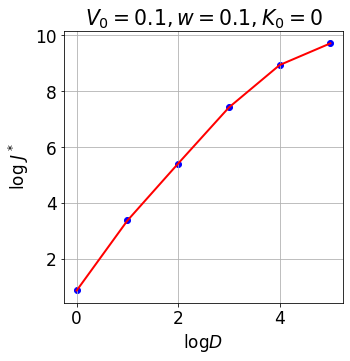

In [133]:
V0 = 0.1
K = 0.1
U0 = 0.1
w = 0.1
D0_range = 10**np.arange(0,6)
Jstar = Jmax_bare_D(D0_range, V0, K0, U0, w)
plt.plot(np.arange(0,6), np.log10(Jstar), color="r")
plt.scatter(np.arange(0,6), np.log10(Jstar), color="b", marker="o")
plt.title(r"$V_0 = {}, w = {}, K_0 = {}$".format(V0, w, 0))
plt.xlabel(r"$\log D$")
plt.ylabel(r"$\log\;J^*$")
#plt.savefig("../figures/J_vs_D.pdf", bbox_inches='tight', format='pdf')
plt.show()

## Scaling of $J^*$ and $V^*$ with system size

100%|██████████| 6/6 [01:44<00:00, 17.37s/it]


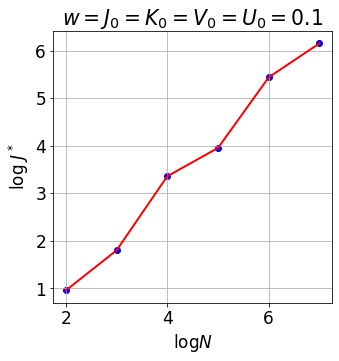

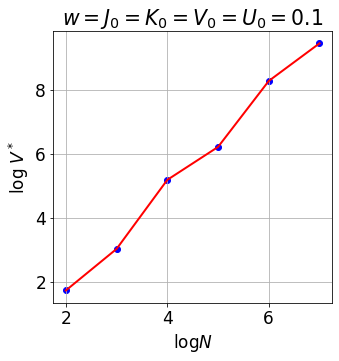

In [19]:
D0_range = 10**np.arange(1, 7)
N = D0_range * 10
m = len(D0_range)
V0 = 0.1 
K0 = 0.1
U0 = 0.1
J0 = 0.1
w = 0.1
Jstar = []
Vstar = []
for D0 in tqdm(D0_range):
    w = 0.1
    outp = complete_RG(w, D0, U0, V0, J0, K0)
    Jstar.append(outp[2][-1])
    Vstar.append(outp[4][-1])
plt.plot(np.log10(N), np.log10(Jstar), color="r")
plt.scatter(np.log10(N), np.log10(Jstar), color="b", marker="o")
plt.title(r"$w = J_0 = K_0 = V_0 = U_0 = {}$".format(w))
plt.xlabel(r"$\log N$")
plt.ylabel(r"$\log\;J^*$")
plt.show()
plt.plot(np.log10(N), np.log10(Vstar), color="r")
plt.scatter(np.log10(N), np.log10(Vstar), color="b", marker="o")
plt.title(r"$w = J_0 = K_0 = V_0 = U_0 = {}$".format(w))
plt.xlabel(r"$\log N$")
plt.ylabel(r"$\log\;V^*$")
plt.show()

## Scaling of $\gamma$ with system size

100%|██████████| 6/6 [04:33<00:00, 45.51s/it]


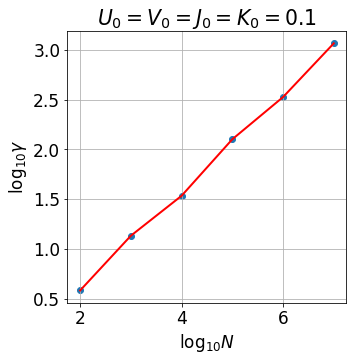

In [34]:
D0_range = 10**np.arange(1,7)
U0 = V0 = J0 = K0 = 0.1
gamma = []
size = []
for D0 in tqdm(D0_range):
    w = 0.1
    outp = complete_RG(w, D0, U0, V0, J0, K0)
    count = outp[6]
    j = outp[2][-1] * count
    v = outp[4][-1]
    U = outp[1][-1] * sqrt(count)
    if v != 0:
        gamma.append((3*j/4 + U/2)/(2*v))
        size.append(np.log10(D0*10))
plt.plot(size, np.log10(gamma), color="r")
plt.scatter(size, np.log10(gamma), marker="o")
plt.xlabel(r"$\log_{10}N$")
plt.ylabel(r"$\log_{10}\gamma$")
plt.title(r"$U_0 = V_0 = J_0 = K_0 = {}$".format(U0))
plt.show()
#U0 = V0 = J0 = K0 = 0.5
#gamma = []
#size = []
#for D0 in tqdm(D0_range):
#    w = 1
#    outp = complete_RG(w, D0, U0, V0, J0, K0)
#    count = outp[6]
#    j = outp[2][-1] * count
#    v = outp[4][-1]
#    U = outp[1][-1] * sqrt(count)
#    if v != 0:
#        gamma.append((3*j/4 + U/2)/(2*v))
#        size.append(np.log10(D0*10))
#plt.plot(size, np.log10(gamma), color="r")
#plt.scatter(size, np.log10(gamma), marker="o")
#plt.xlabel(r"$\log_{10}N$")
#plt.ylabel(r"$\log_{10}\gamma$")
#plt.title(r"$U_0 = V_0 = J_0 = K_0 = {}$".format(U0))
#plt.show()

## Comparison of $J^*$ and $V^*$

In [19]:
def count_Vfp(D0, V0, J0, K0, sign, delta=0.1):
    w_range = np.arange(-D0/2, D0/2, delta)
    U_range = np.arange(sign*delta, sign*(5 + delta), sign*delta)
    data = itertools.product(w_range, [D0], U_range, [V0], [J0], [K0])
    c0, cJ, cV = 0, 0, 0
    for outp in Pool(processes=50).starmap(complete_RG, data):
        x, y1, y2, y3, y4, flag, y5 = outp
        if flag == True or (y2[-1] == 0 and y4[-1] == 0):
            if y2[-1] > y4[-1]:
                cJ += 1
            elif y2[-1] < y4[-1]:
                cV += 1
            else:
                c0 += 1
    return c0, cJ, cV

In [20]:
def plot_JvsV(D0_range, V0_range, J0_range, K0, sign, title):
    for D0 in D0_range:
        print (D0)
        for J0 in J0_range:
            C0, CJ, CV = [], [], []
            for V0 in V0_range:
                c0, cJ, cV = count_Vfp(D0, V0, J0, K0, sign)
                C0.append(c0/(c0+cJ+cV))
                CJ.append(cJ/(c0+cJ+cV))
                CV.append(cV/(c0+cJ+cV))
            plt.plot(V0_range, C0, label=r"$J^* = V^*$")
            plt.plot(V0_range, CJ, label=r"$J^* > V^*$")
            plt.plot(V0_range, CV, label=r"$J^* < V^*$")
            plt.legend()
            plt.title(title+r"$D={}, J={}$".format(D0, J0))
            plt.show()

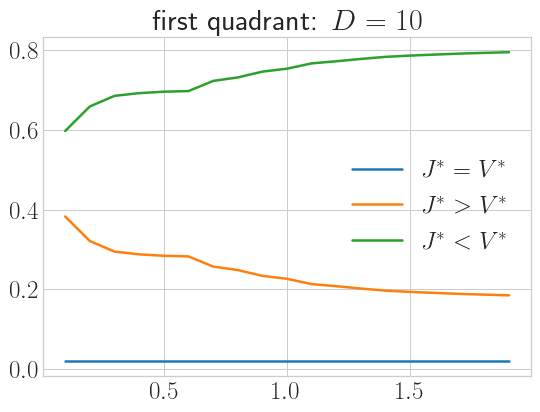

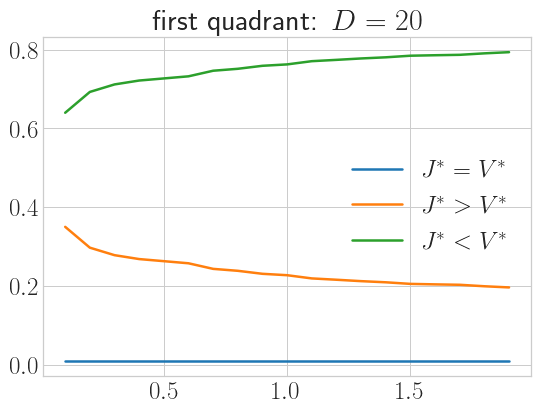

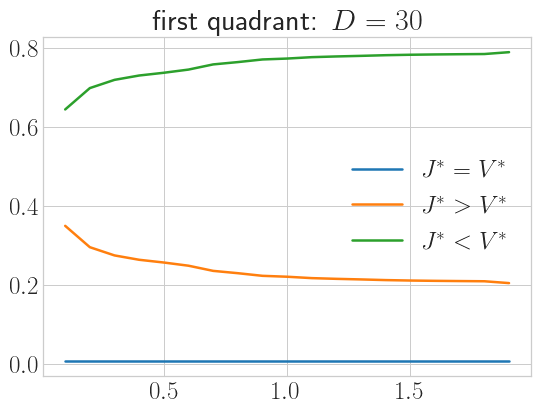

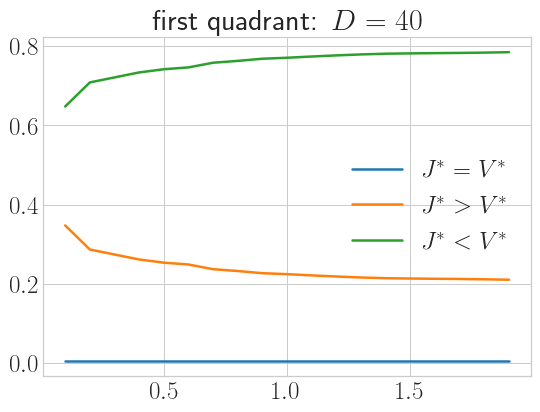

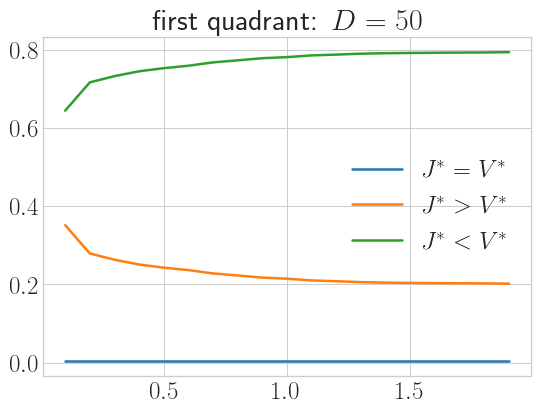

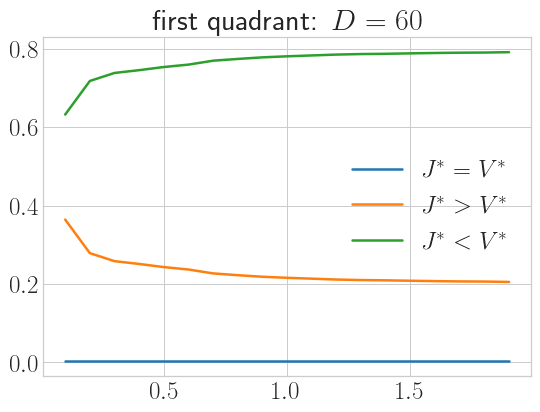

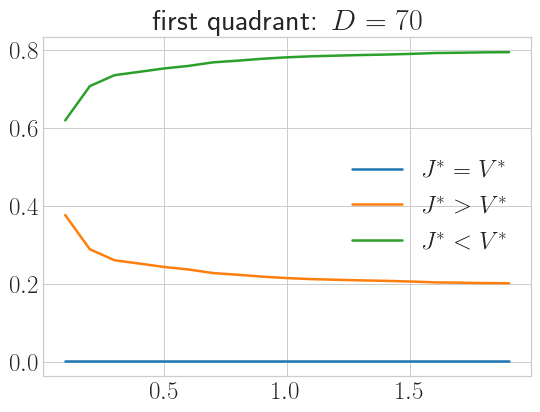

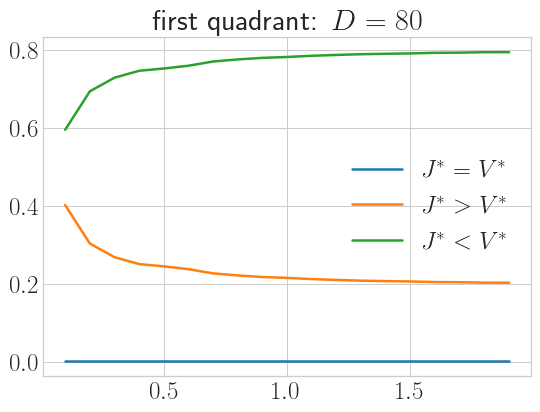

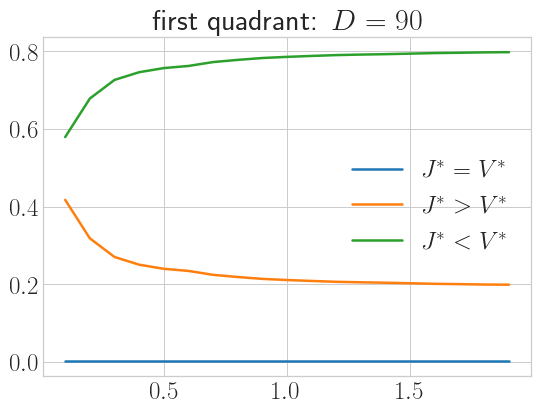

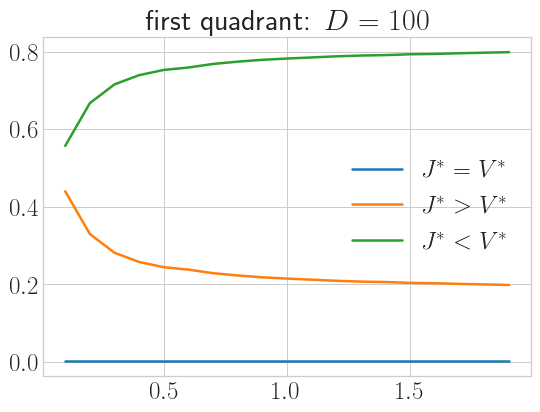

In [18]:
plot_JvsV(range(10,60,30), np.arange(0.1,2,0.1), 0.5, 0.4, 1, r'first quadrant: ')

10


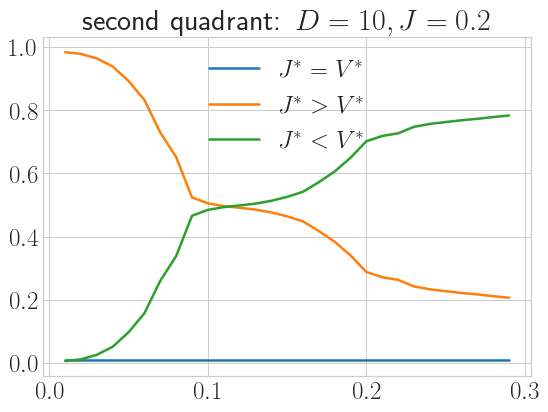

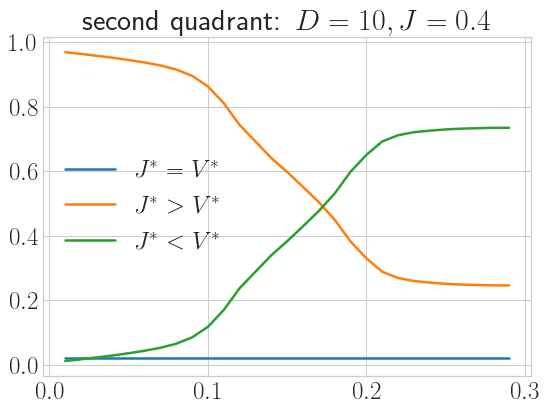

20


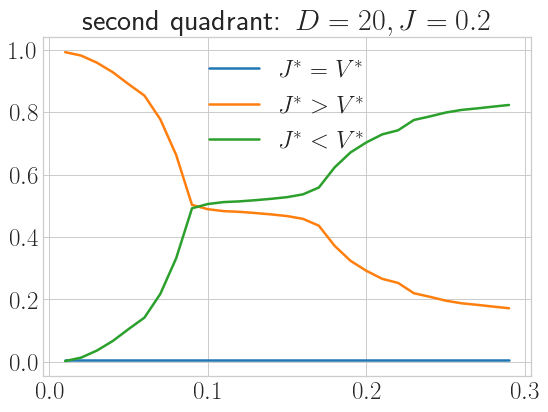

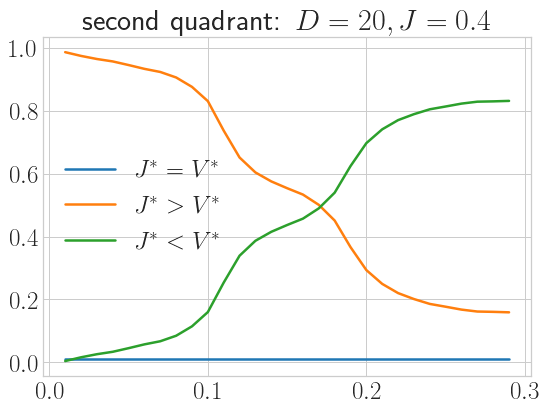

30


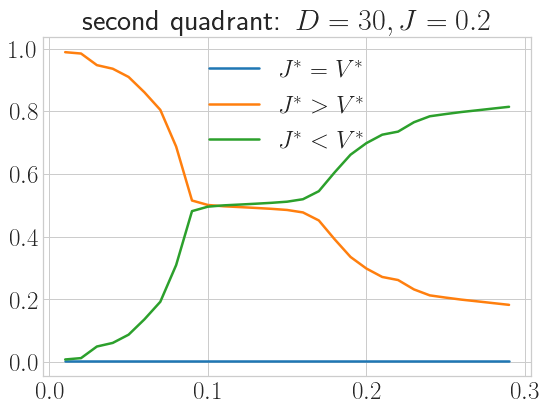

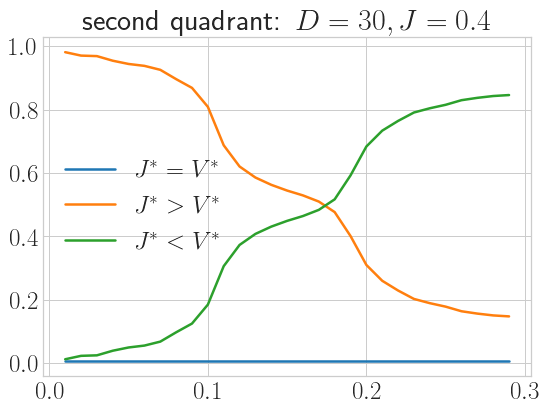

In [21]:
plot_JvsV(range(10,31,10), np.arange(0.01,0.3,0.01), [0.2, 0.4], 0.5, 1, r'second quadrant: ')

10


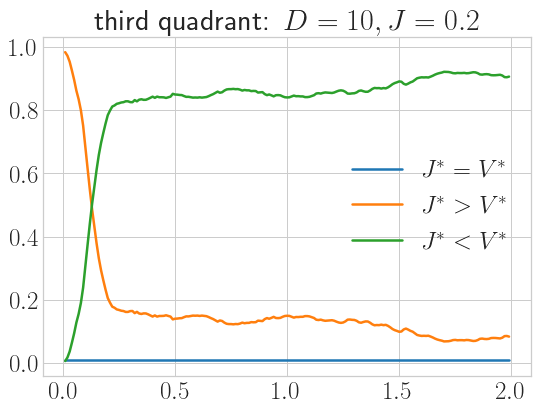

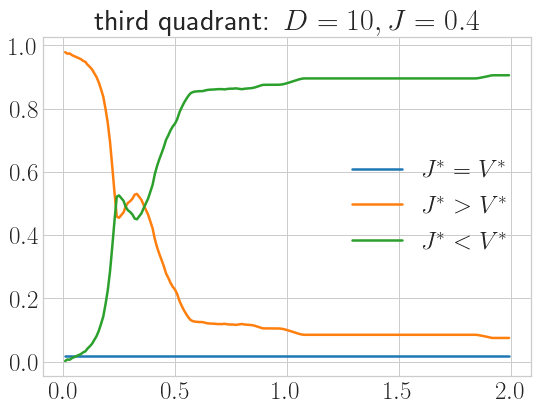

30


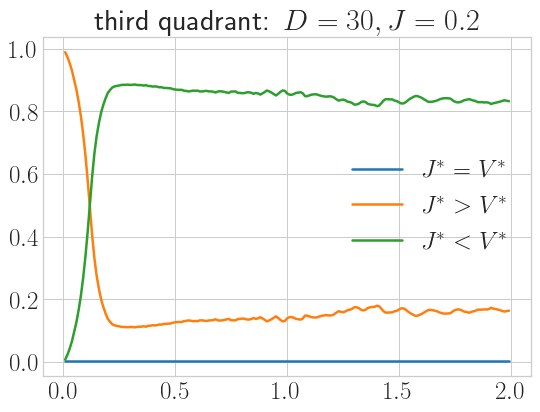

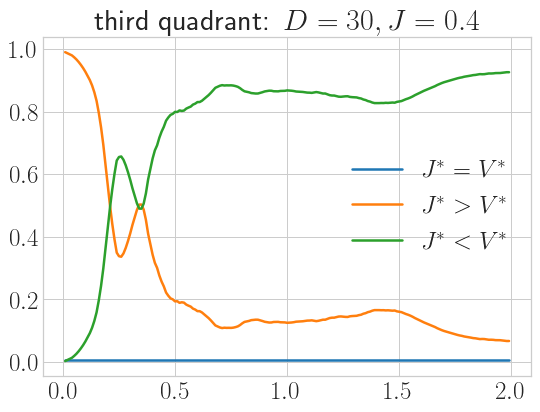

60


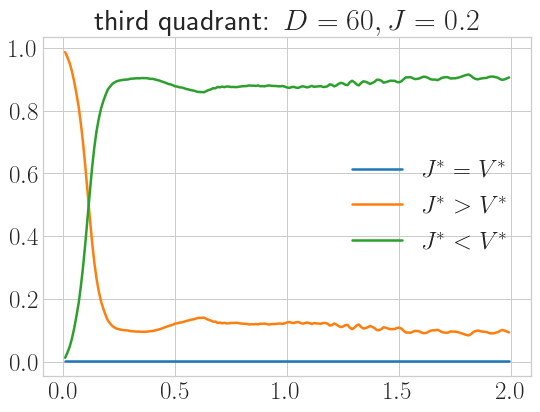

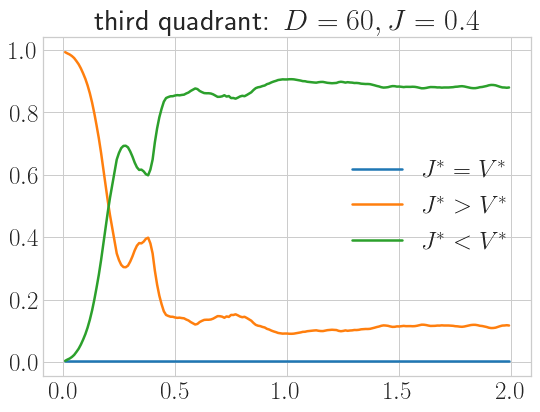

In [22]:
plot_JvsV([10, 30, 60], np.arange(0.01,2,0.01), [0.2, 0.4], 0.5, -1, r'third quadrant: ')

10


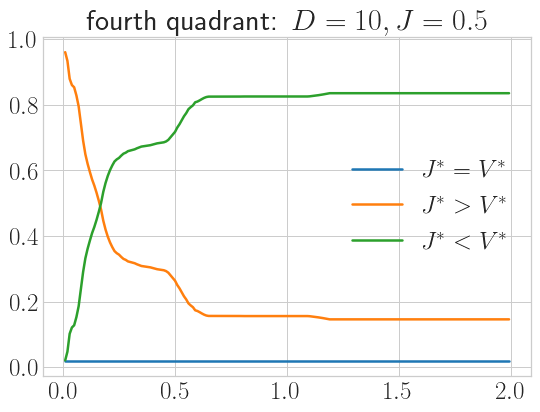

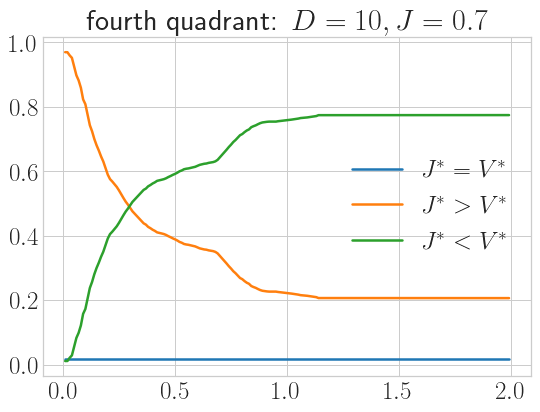

30


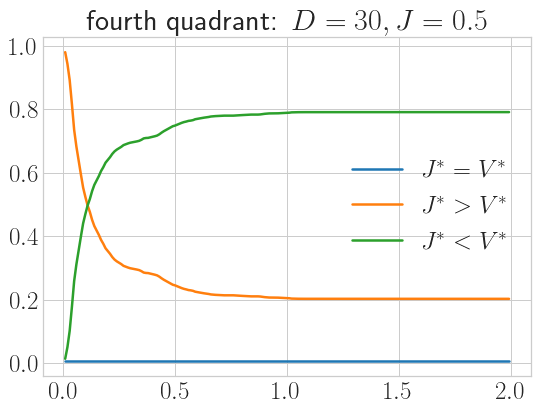

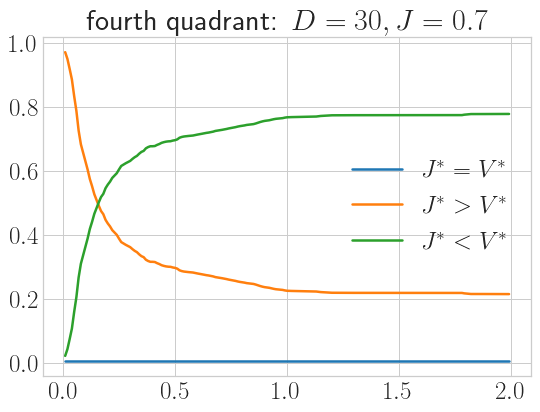

60


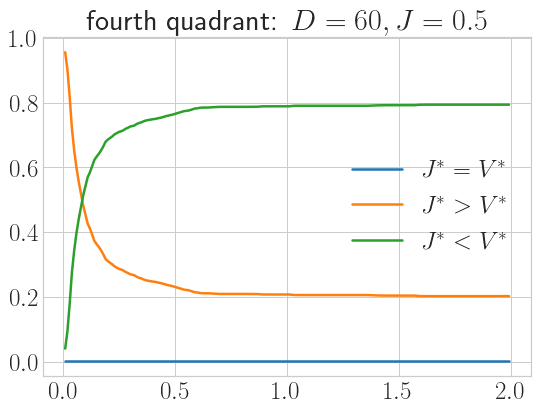

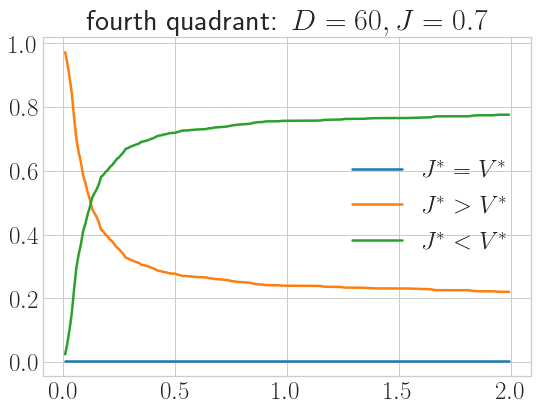

In [23]:
plot_JvsV([10, 30, 60], np.arange(0.01,2,0.01), [0.5, 0.7], 0.4, -1, r'fourth quadrant: ')

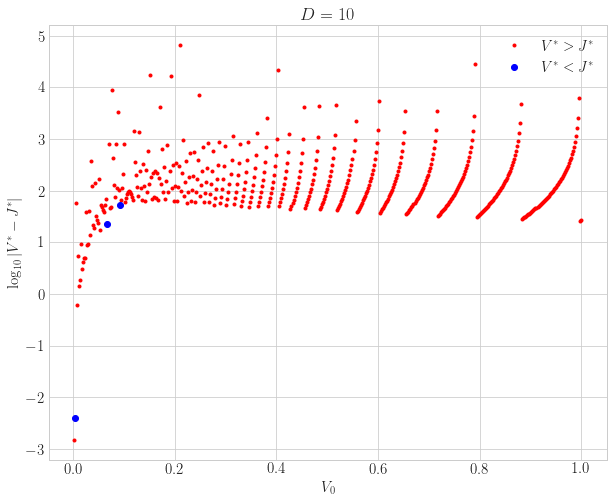

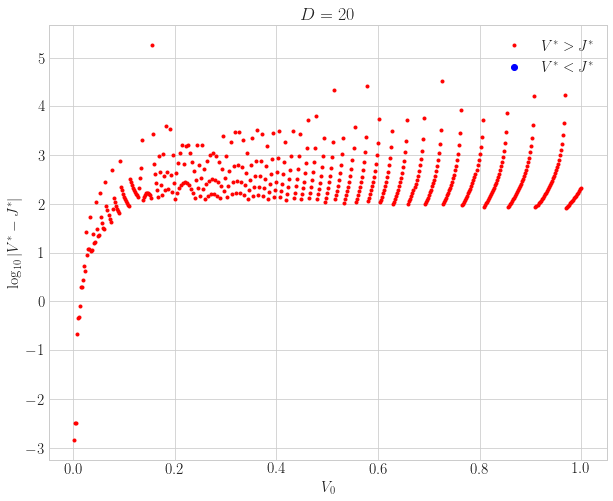

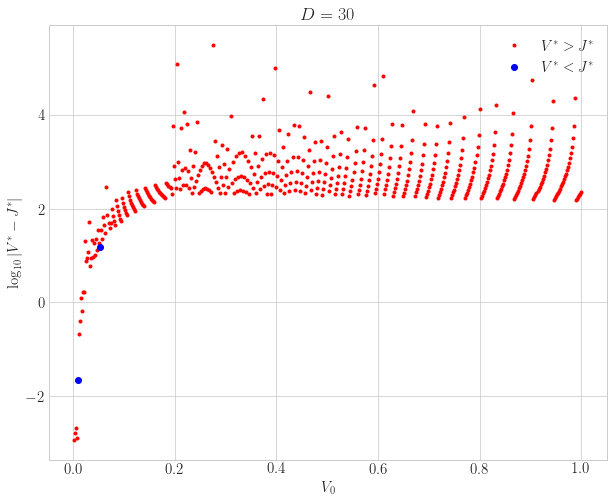

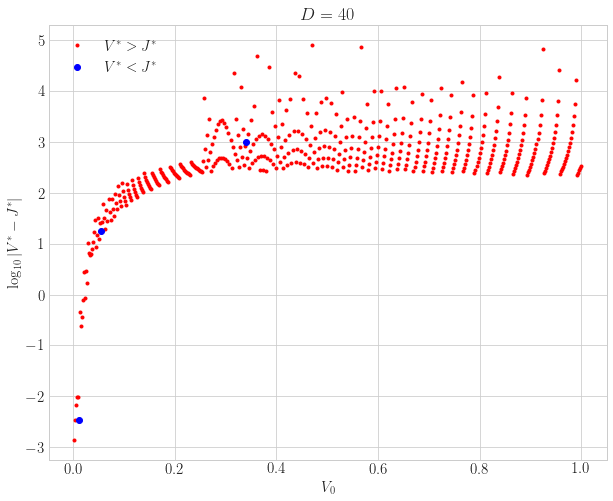

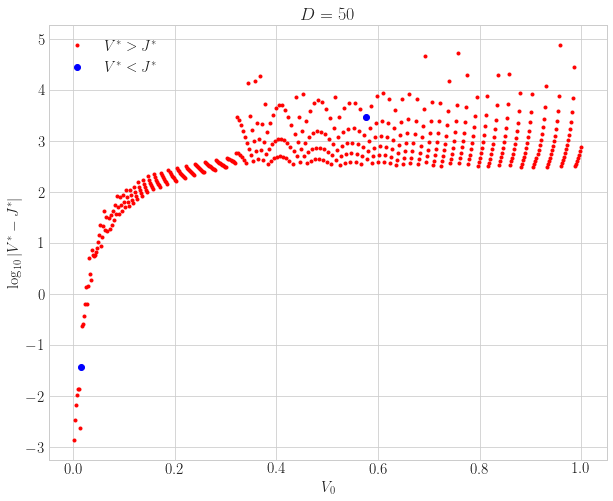

In [22]:
plot_JvsV(-1, 1, r'second quadrant')

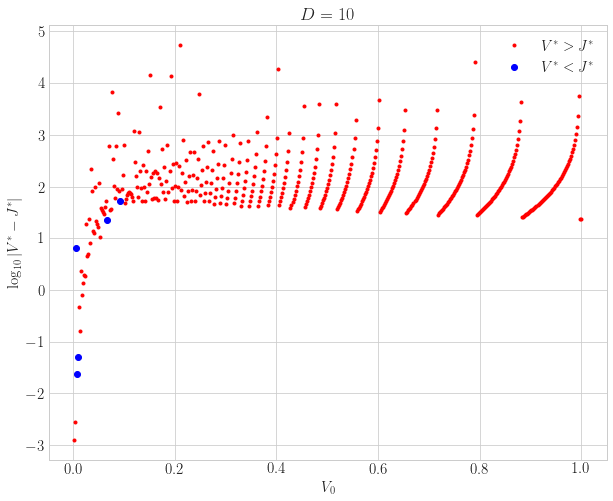

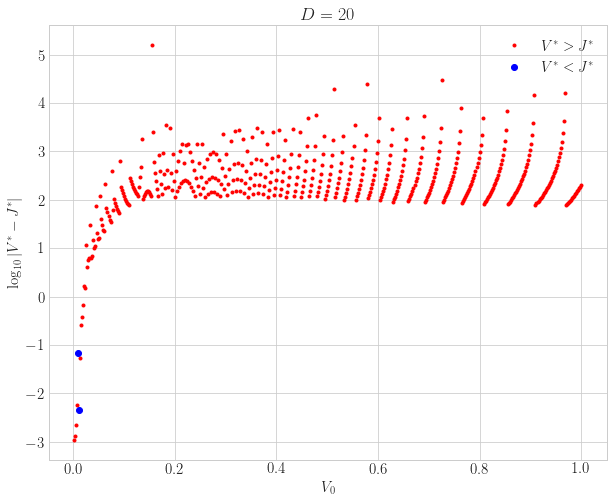

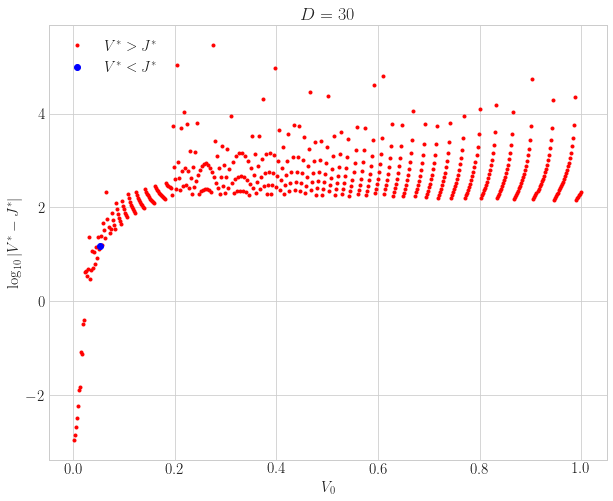

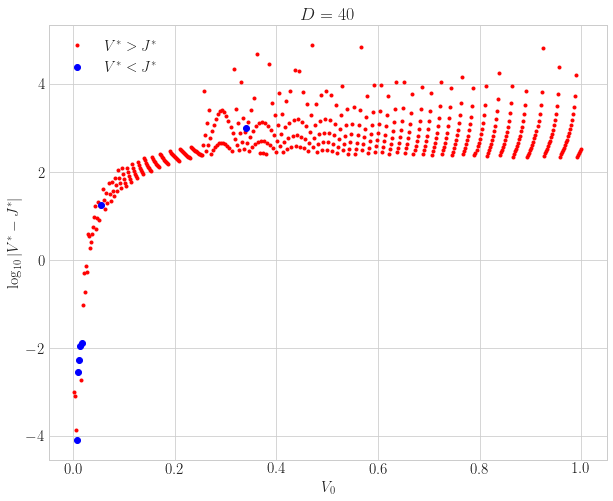

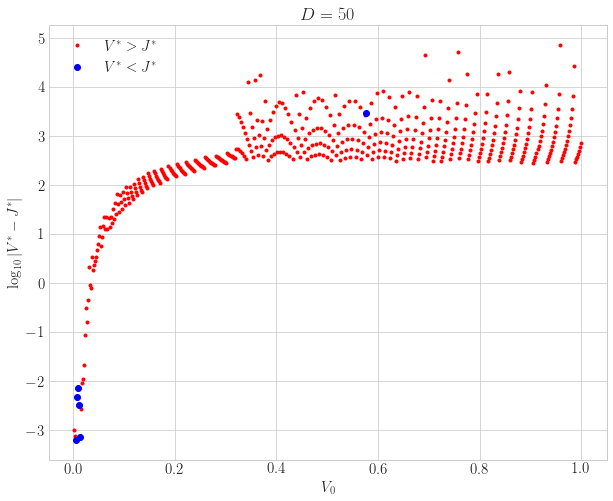

In [23]:
plot_JvsV(-1, -1, r'third quadrant')

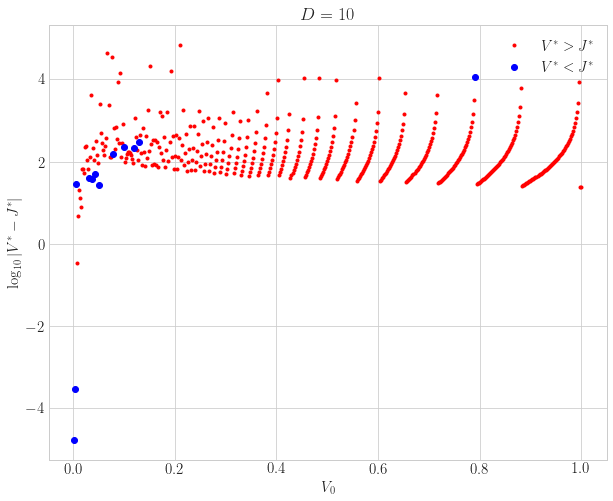

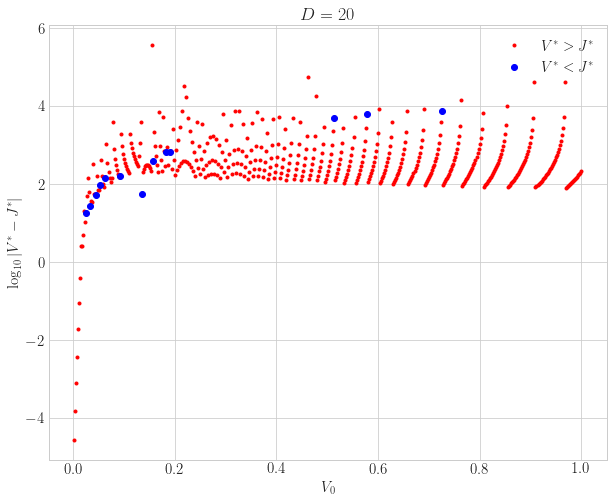

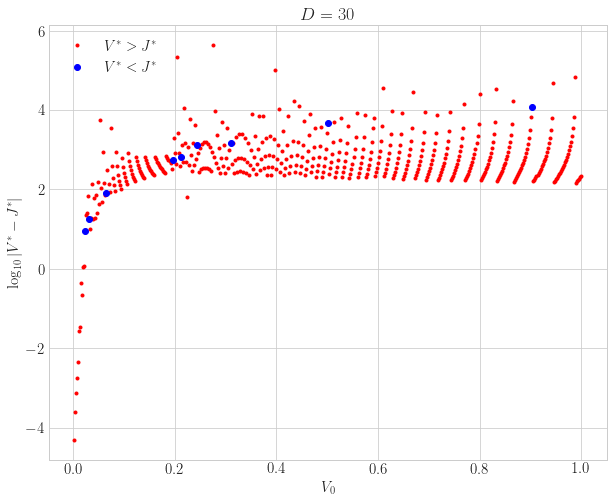

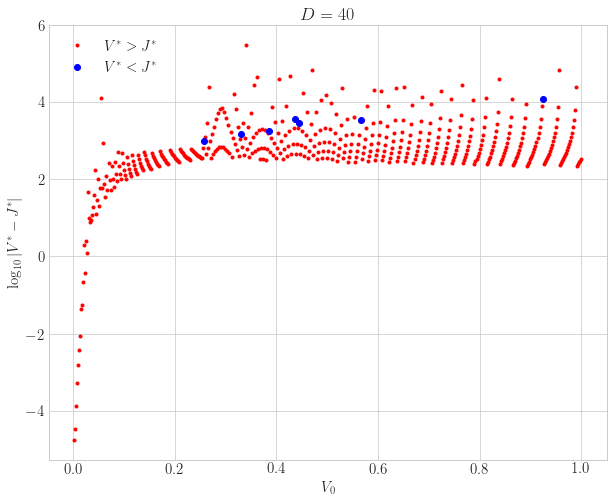

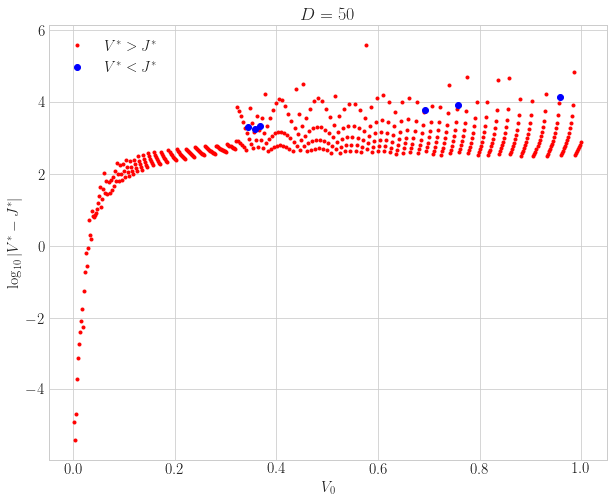

In [24]:
plot_JvsV(1, -1, r'fourth quadrant')

## Behaviour of $V$

In [16]:
def count_Vfp(D0, V0, J0, K0, sign=1, delta=0.05):
    w_range = np.arange(-D0/2, D0/2, delta)
    U_range = np.arange(sign*delta, sign*(10 + delta), sign*delta)
    data = itertools.product(w_range, [D0], U_range, [V0], [J0], [K0])
    count = np.zeros(3)
    for outp in Pool(processes=50).starmap(complete_RG, data):
        V_fp = outp[4][-1]
        if V_fp ==0:
            count[0] += 1
        elif V_fp > V0:
            count[1] += 1
        elif V_fp < V0:
            count[2] += 1
    return count

def plot_Vcount(V0_range, count, title):
    plt.plot(V0_range, count[0], marker=".", color='r', label=r"$V^*=0$" )
    plt.plot(V0_range, count[1], marker=".", color='b', label=r"$V^* > V_0$")
    plt.plot(V0_range, count[2], marker=".", color='g', label=r"$V^* < V_0$")
    plt.legend()
    plt.title(title)
    plt.xlabel(r"$V_0$")
    plt.ylabel(r"fraction of fixed points")
    plt.show()

def plot_all(J0, K0, sign, title, V0_range=np.arange(0.001,0.101,0.001), D0_range = range(10, 20, 3)):
    for D0 in D0_range:
        c0, c1, c2 = [], [], []
        for V0 in V0_range:
            print (V0)
            count = count_Vfp(D0, V0, J0, K0, sign)
            c0.append(count[0]/sum(count))
            c1.append(count[1]/sum(count))
            c2.append(count[2]/sum(count))
        plot_Vcount(V0_range, [c0, c1, c2], title+r", $D={}$".format(D0))

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

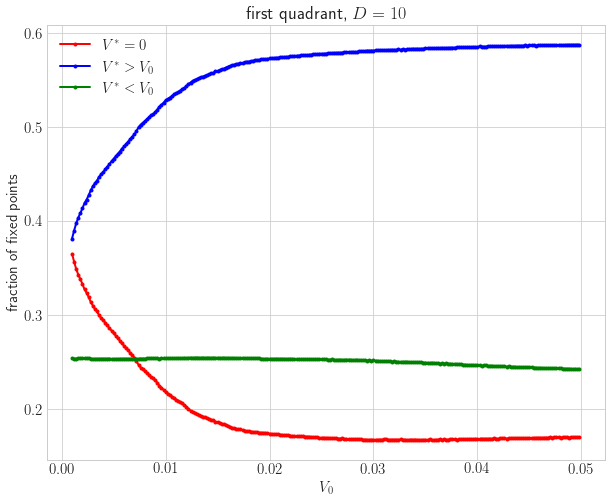

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

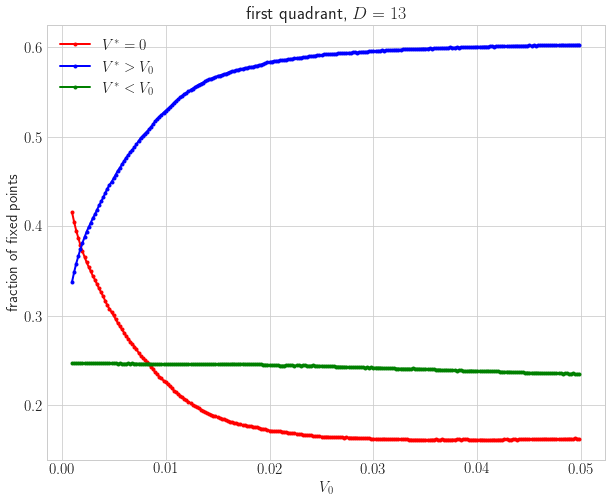

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

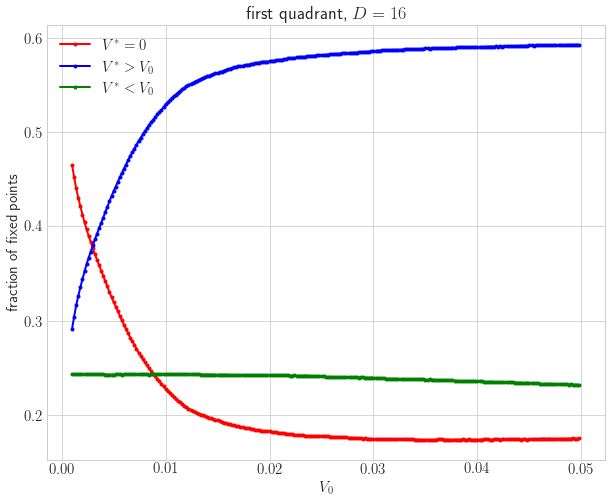

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

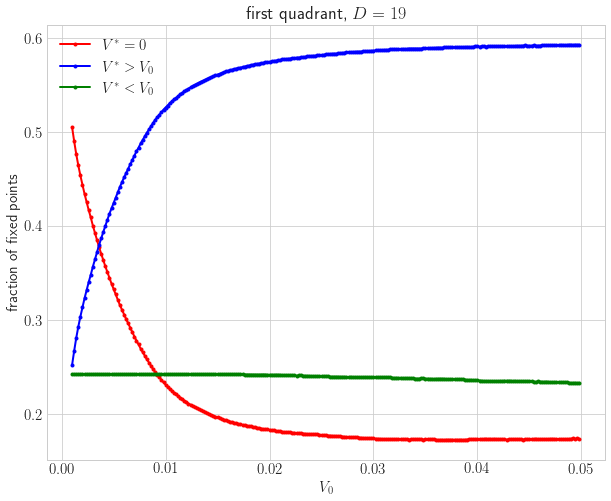

In [17]:
V0_range = np.arange(0.001,0.05,0.0002)
plot_all(0.2, 0.1, 1, r"first quadrant", V0_range=V0_range)

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


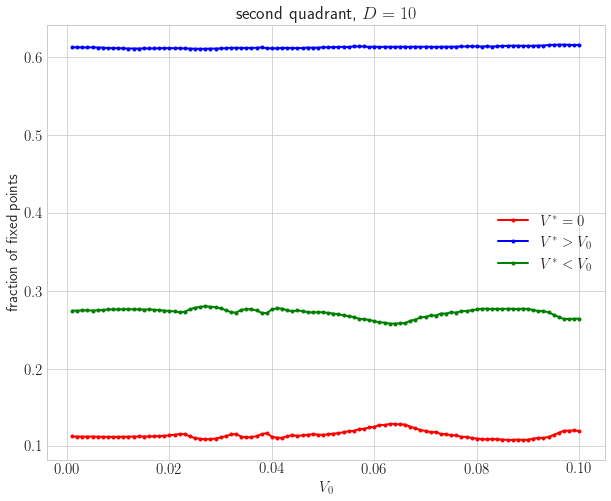

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


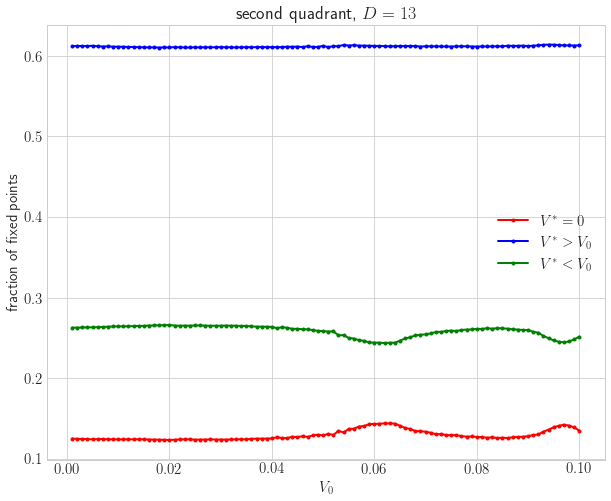

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


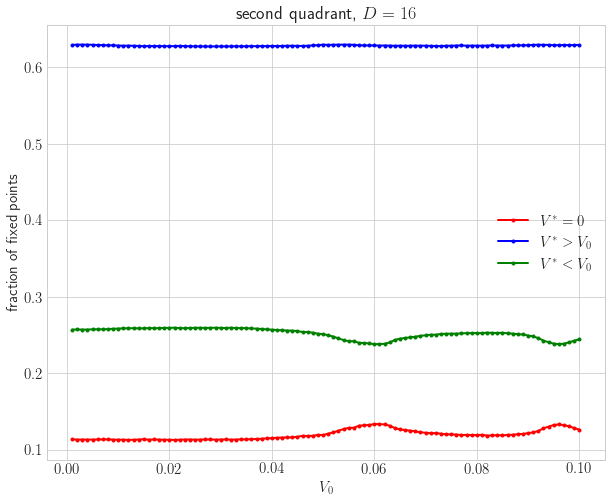

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


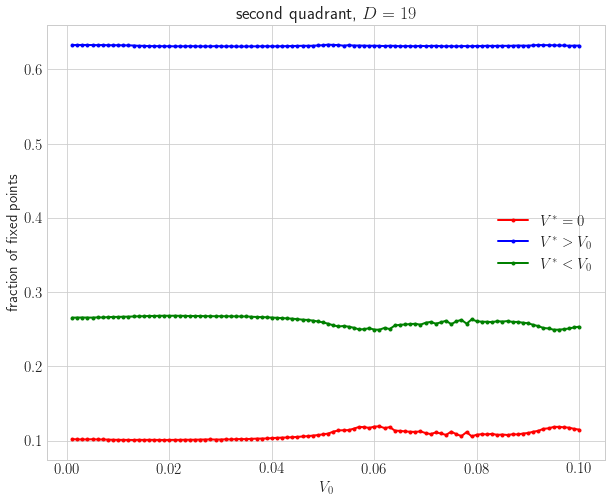

In [18]:
plot_all(0.1, 0.2, 1, r"second quadrant")

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


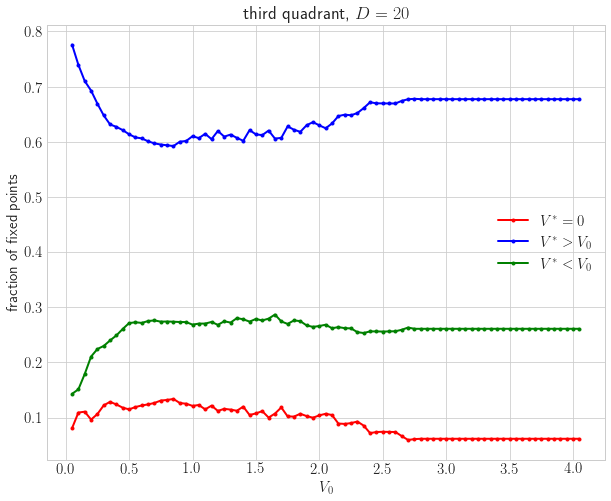

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


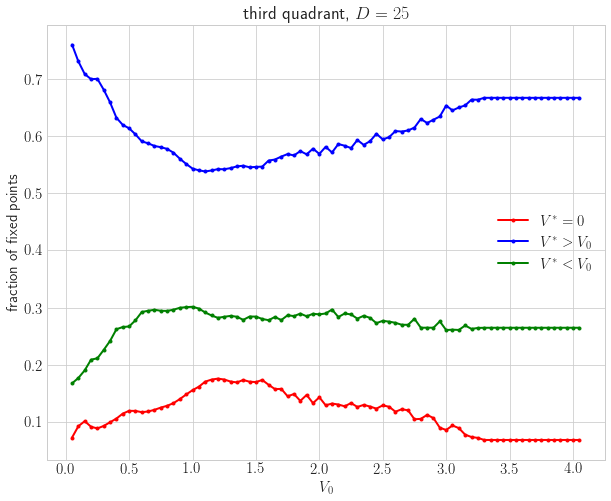

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


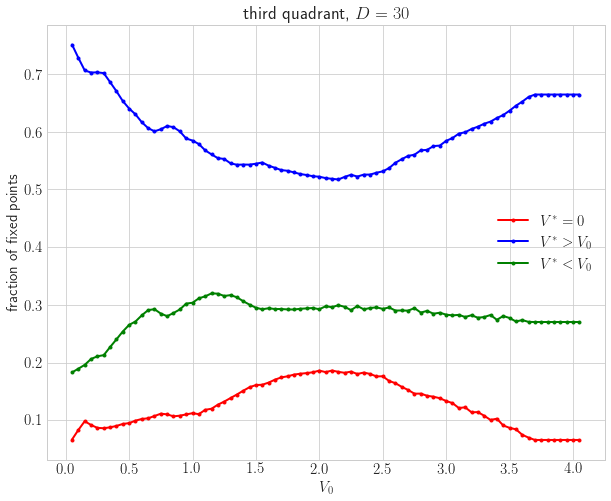

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


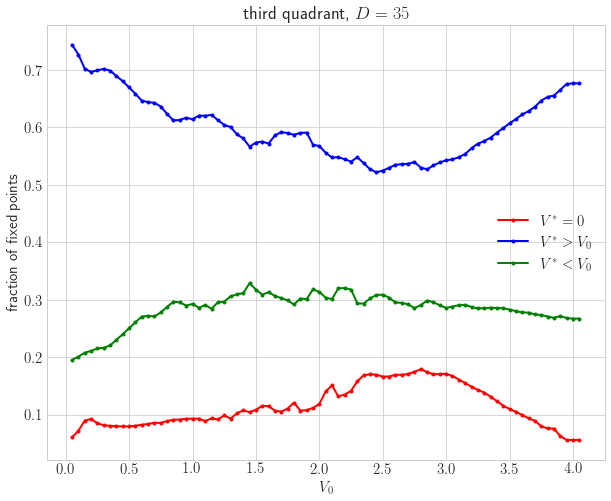

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


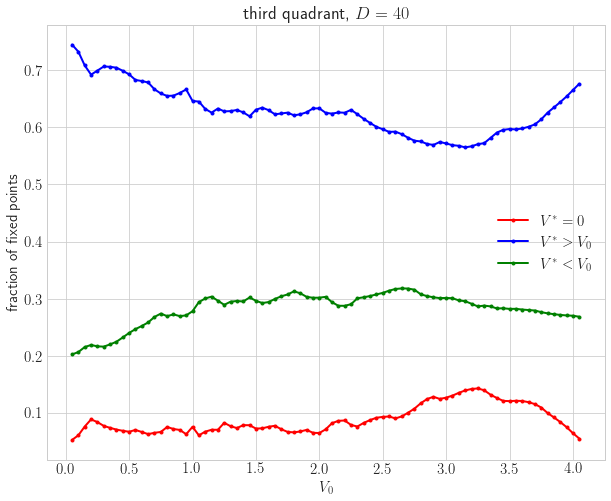

In [19]:
plot_all(0.1, 0.2, -1, r"third quadrant", V0_range=np.arange(0.05,4.1,0.05), D0_range=np.arange(20, 41, 5))

In [ ]:
plot_all(0.2, 0.1, -1, r"fourth quadrant", V0_range=np.arange(0.01,1,0.01))

## b. Change in the fraction of irrelevant fixed points under increase in $D$

Next we will see how the ratio of number of fixed points in each class varies as we increase the bandwidth, for a particular $V \sim 10$ in the stable region.

In [ ]:
def plot_frac(J0, K0, sign, title):
    D0_range = np.arange(10,91,20)
    frac = [].05
    for D0 in D0_range:
        print (D0)
        V0 = 10
        count = (count_fp(D0, V0, J0, K0, sign))
        frac.append(count[0]/sum(count))
    plt.plot(D0_range, frac, marker=".")
    plt.title(title)
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"log of ratio of irr. to rel.")
    plt.show()


#plot_frac(0.04, 0.03, 1, r"first quadrant")
#plot_frac(0.03, 0.04, 1, r"second quadrant")
#plot_frac(0.03, 0.04, -1, r"third quadrant")
#plot_frac(0.04, 0.03, -1, r"fourth quadrant")

## c. Change in the critical $V$ under increase in $D$

For the first and third quadrants, there is a critical value of $V$ at which the number of relevant and irrelevant fixed points become equal. We will now see how this value depends on the bandwidth $D$.

In [ ]:

def Vc_vs_D(J0, K0, sign, title):
    D0_range = range(10,91,20)
    Vc = [get_Vc(D0, J0, K0, sign, title) for D0 in D0_range]
    plt.plot(D0_range, Vc, marker=".")
    plt.title(title)
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"$V_c$")
    plt.show()


#Vc_vs_D(0.4, 0.3, 1, r"first quadrant")
#Vc_vs_D(0.3, 0.4, -1, r"third quadrant")